# Installations and Imports

In [2]:
!pip install -q pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00


In [27]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.statistics.traces.generic.log import case_statistics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from collections import Counter, defaultdict
from datetime import timedelta
import statistics
import plotly.express as px
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
from pm4py.visualization.process_tree import visualizer as pt_visualizer

# Data loading and Preprocessing

In [4]:
# load the data
log = xes_importer.apply('/content/Sepsis Cases - Event Log.xes.gz')

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

In [6]:
lab_keys = {"CRP", "Leucocytes", "LacticAcid"}

for idx, trace in enumerate(log):
    seen_events = {}

    for event in trace:
        key = (event.get("concept:name"), event.get("time:timestamp"))
        if key not in seen_events:
            seen_events[key] = [event]
        else:
            seen_events[key].append(event)

    # Rebuild the trace with only one event per (name, timestamp) pair
    cleaned_events = []
    for key, events in seen_events.items():
        if len(events) == 1:
            cleaned_events.append(events[0])
        else:
            print(f"Trace #{idx} removed duplicate {key[0]} event at {key[1]}")
            # Keep the one that contains the actual measurement (e.g., CRP value)
            events_with_value = [
                e for e in events
                if any(k in e and isinstance(e[k], (int, float)) for k in lab_keys if k == key[0])
            ]
            if events_with_value:
                cleaned_events.append(events_with_value[0])
            else:
                cleaned_events.append(events[0])  # fallback

    # Sort the cleaned trace in-place by timestamp
    cleaned_events.sort(key=lambda e: e.get("time:timestamp"))

    # Replace the original trace content with the cleaned version
    trace[:] = cleaned_events

Trace #357 removed duplicate Leucocytes event at 2014-09-25 11:09:00
Trace #362 removed duplicate CRP event at 2014-04-15 09:00:00
Trace #362 removed duplicate Leucocytes event at 2014-04-15 09:00:00
Trace #413 removed duplicate Leucocytes event at 2014-06-05 08:00:00
Trace #413 removed duplicate CRP event at 2014-06-05 08:00:00
Trace #497 removed duplicate Leucocytes event at 2014-11-08 05:50:00
Trace #870 removed duplicate LacticAcid event at 2014-06-18 07:00:00


# EDA

In [6]:
print("Total amount of patient pathways:", len(log))
print(f"Total number of events in the log: {sum(len(trace) for trace in log)}")

Total amount of patient pathways: 1050
Total number of events in the log: 15207


## What does a single log trace look like?

In [7]:
# Select the trace (e.g., first one)
trace = log[0]

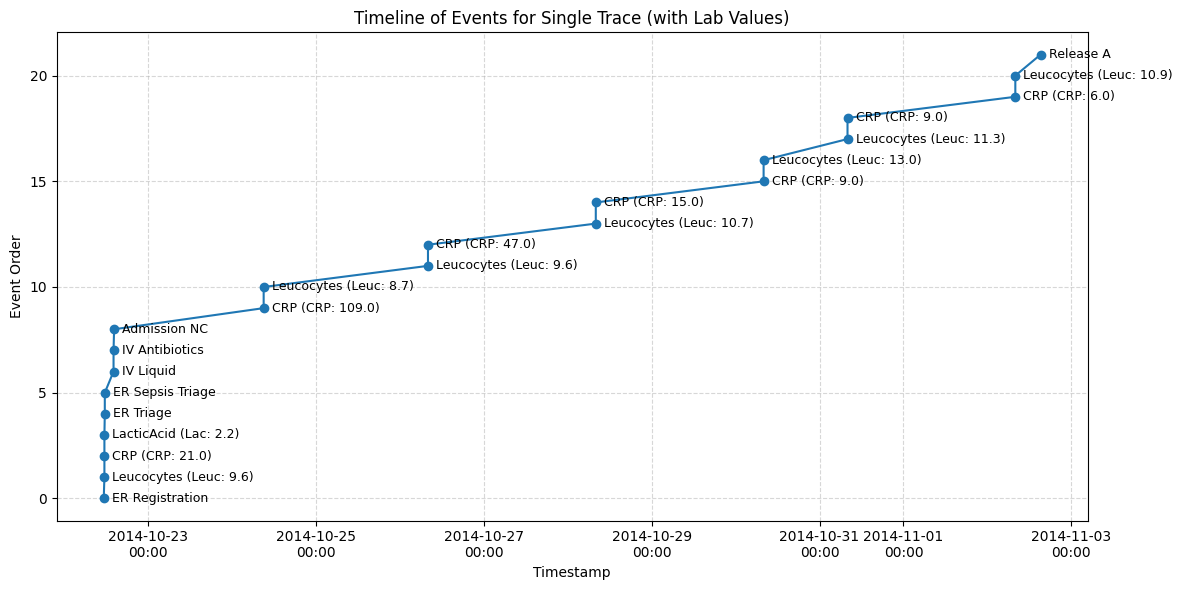

In [8]:
# Extract event names and timestamps
event_labels = []
timestamps = []

for event in trace:
    name = event.get('concept:name', 'Unknown')
    label = name

    # Append lab value if available
    if 'CRP' in event:
        label += f" (CRP: {event['CRP']})"
    if 'Leucocytes' in event:
        label += f" (Leuc: {event['Leucocytes']})"
    if 'LacticAcid' in event:
        label += f" (Lac: {event['LacticAcid']})"

    event_labels.append(label)
    timestamps.append(event['time:timestamp'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(timestamps, list(range(len(timestamps))), marker='o', linestyle='-', color='tab:blue')

# Add labels
for i, (label, ts) in enumerate(zip(event_labels, timestamps)):
    plt.text(ts, i, f'  {label}', verticalalignment='center', fontsize=9)

# Formatting
plt.title('Timeline of Events for Single Trace (with Lab Values)')
plt.xlabel('Timestamp')
plt.ylabel('Event Order')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

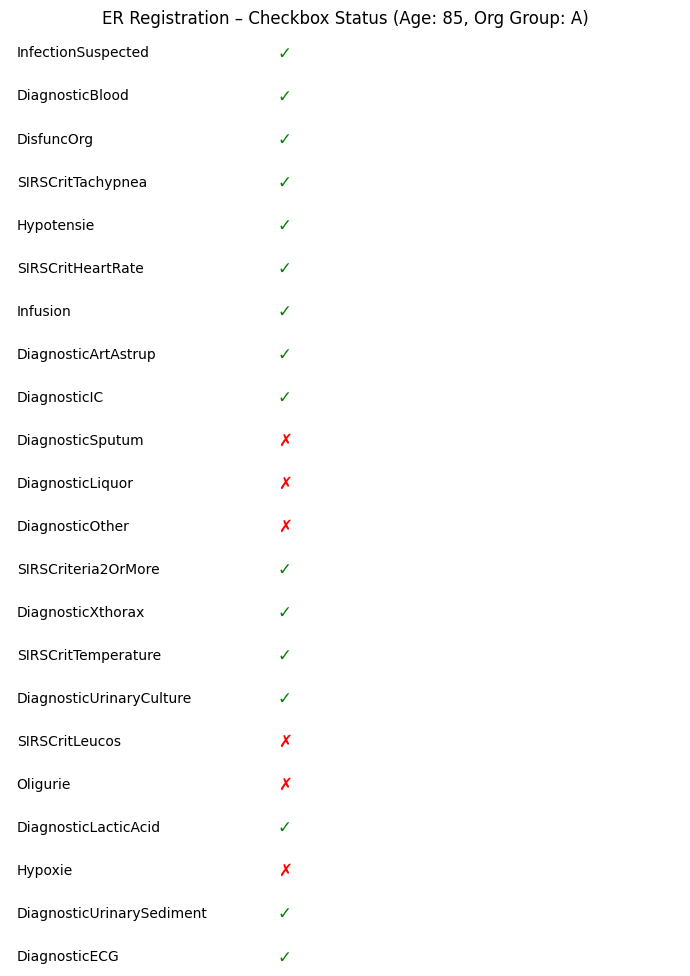

In [9]:
# Extract the first event (ER Registration)
er_registration_event = trace[0]

# Extract checkbox-like fields
checkbox_fields = {k: v for k, v in er_registration_event.items() if isinstance(v, bool)}

# Extract age and org group for the title
age = er_registration_event.get("Age", "Unknown")
org_group = er_registration_event.get("org:group", "Unknown")

# Convert to DataFrame
df = pd.DataFrame.from_dict(checkbox_fields, orient='index', columns=['Checked'])
df['Status'] = df['Checked'].apply(lambda x: '✓' if x else '✗')
df['Color'] = df['Checked'].apply(lambda x: 'green' if x else 'red')

# Plot the checkbox matrix
fig, ax = plt.subplots(figsize=(7, len(df) * 0.4 + 1))  # Adjust height for title spacing
ax.axis('off')

# Spacing parameters
row_height = 0.05
start_y = 0.99  # start slightly below the title

# Add each row manually
for i, (label, row) in enumerate(df.iterrows()):
    y_pos = start_y - i * 0.05
    ax.text(0.01, y_pos, label, fontsize=10, ha='left', va='center')
    ax.text(0.4, y_pos, row['Status'], fontsize=12, color=row['Color'], ha='left', va='center')

# Title includes age and org group
plt.title(f"ER Registration – Checkbox Status (Age: {age}, Org Group: {org_group})", fontsize=12, pad=15)
plt.tight_layout()
plt.show()

## What are all the possible events?

In [10]:
# Plotting helper
def plot_counter(counter, title, xlabel, color='skyblue'):
    labels, values = zip(*sorted(counter.items(), key=lambda x: x[1], reverse=True))
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

🔹 Unique concept:name values:
['Admission IC', 'Admission NC', 'CRP', 'ER Registration', 'ER Sepsis Triage', 'ER Triage', 'IV Antibiotics', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'Release A', 'Release B', 'Release C', 'Release D', 'Release E', 'Return ER']


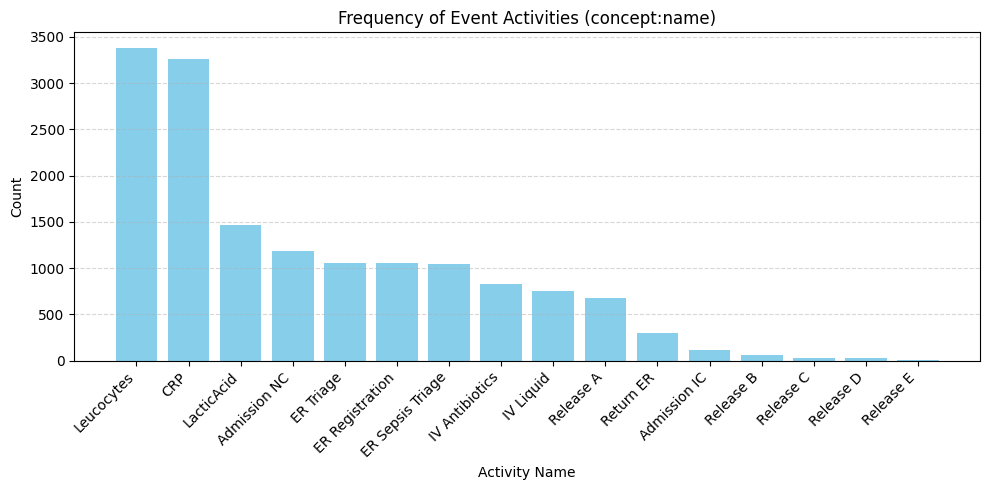


🔹 Unique lifecycle:transition values:
['complete']

🔹 Unique org:group values:
['?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


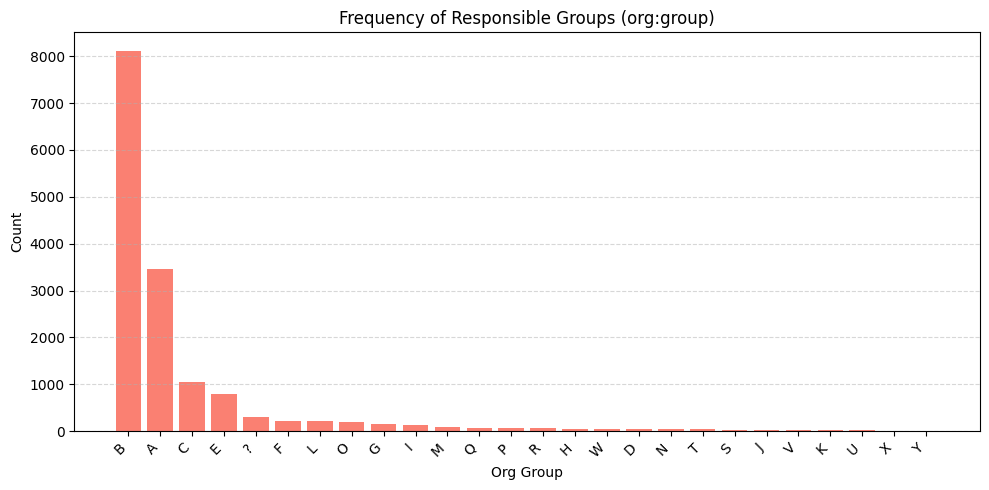

In [11]:
concept_names = set()
lifecycle_transitions = set()
org_groups = set()

# Count occurrences
concept_counter = Counter()
org_group_counter = Counter()

for trace in log:
    for event in trace:
        concept_names.add(event.get("concept:name"))
        lifecycle_transitions.add(event.get("lifecycle:transition"))
        org_groups.add(event.get("org:group"))
        concept_counter[event.get("concept:name")] += 1
        org_group_counter[event.get("org:group")] += 1

print("🔹 Unique concept:name values:")
print(sorted(concept_names))
plot_counter(concept_counter, "Frequency of Event Activities (concept:name)", "Activity Name")


print("\n🔹 Unique lifecycle:transition values:")
print(sorted(lifecycle_transitions))

print("\n🔹 Unique org:group values:")
print(sorted(org_groups))
plot_counter(org_group_counter, "Frequency of Responsible Groups (org:group)", "Org Group", color='salmon')

## ER Registraion data

In [12]:
not_starting_with_er = 0
er_later_in_trace = 0
no_er_at_all = 0

for trace in log:
    if len(trace) == 0:
        continue

    first_event_name = trace[0].get("concept:name", "")

    if first_event_name != "ER Registration":
        not_starting_with_er += 1

        # Check if ER Registration appears anywhere in the trace
        if any(event.get("concept:name") == "ER Registration" for event in trace):
            er_later_in_trace += 1
        else:
            no_er_at_all += 1

print(f"Total traces: {len(log)}")
print(f"Traces NOT starting with 'ER Registration': {not_starting_with_er}")
print(f"→ of those, traces where 'ER Registration' appears later: {er_later_in_trace}")
print(f"→ traces that do NOT contain 'ER Registration' at all: {no_er_at_all}")

Total traces: 1050
Traces NOT starting with 'ER Registration': 55
→ of those, traces where 'ER Registration' appears later: 55
→ traces that do NOT contain 'ER Registration' at all: 0


In [13]:
er_registration_keys = set()
er_registration_key_counts = Counter()

for trace in log:
    for event in trace:
        if event.get("concept:name") == "ER Registration":
            er_registration_keys.update(event.keys())
            er_registration_key_counts.update(event.keys())

print("🔑 Unique keys found in all 'ER Registration' events:")
for key in sorted(er_registration_keys):
    amount = er_registration_key_counts[key]
    print(f"  - {key} (appears in {'all' if amount==1050 else amount} traces)")

🔑 Unique keys found in all 'ER Registration' events:
  - Age (appears in 995 traces)
  - Diagnose (appears in 754 traces)
  - DiagnosticArtAstrup (appears in all traces)
  - DiagnosticBlood (appears in all traces)
  - DiagnosticECG (appears in all traces)
  - DiagnosticIC (appears in all traces)
  - DiagnosticLacticAcid (appears in all traces)
  - DiagnosticLiquor (appears in all traces)
  - DiagnosticOther (appears in all traces)
  - DiagnosticSputum (appears in all traces)
  - DiagnosticUrinaryCulture (appears in all traces)
  - DiagnosticUrinarySediment (appears in all traces)
  - DiagnosticXthorax (appears in all traces)
  - DisfuncOrg (appears in all traces)
  - Hypotensie (appears in all traces)
  - Hypoxie (appears in all traces)
  - InfectionSuspected (appears in all traces)
  - Infusion (appears in all traces)
  - Oligurie (appears in all traces)
  - SIRSCritHeartRate (appears in all traces)
  - SIRSCritLeucos (appears in all traces)
  - SIRSCritTachypnea (appears in all trace

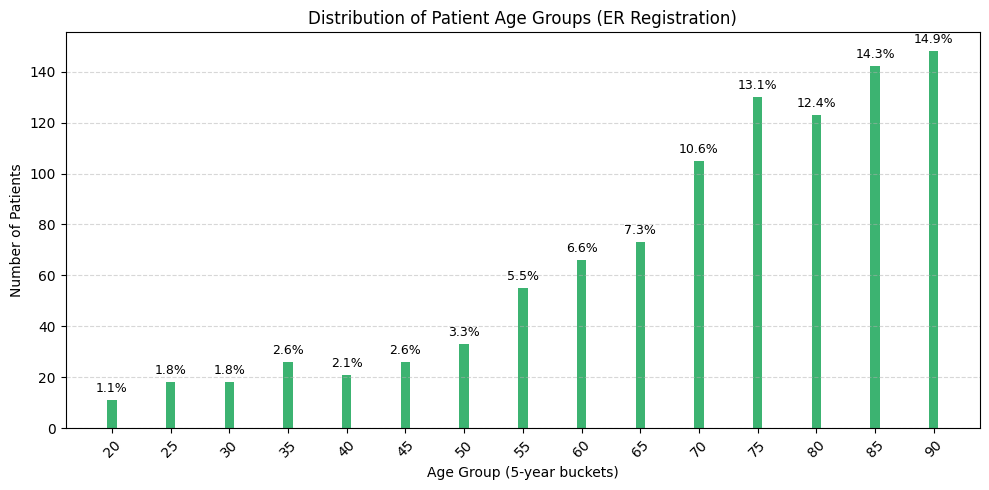

In [14]:
age_counter = Counter()

for trace in log:
    for event in trace:
        if event.get("concept:name") == "ER Registration" and "Age" in event:
            age_counter[event["Age"]] += 1

labels, values = zip(*age_counter.items())
total = sum(values)
percentages = [v / total * 100 for v in values]
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='mediumseagreen')
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f"{pct:.1f}%", ha='center', va='bottom', fontsize=9)

plt.title("Distribution of Patient Age Groups (ER Registration)")
plt.xlabel("Age Group (5-year buckets)")
plt.ylabel("Number of Patients")
plt.xticks(labels, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [15]:
diagnose_values = set()

for trace in log:
    for event in trace:
        if event.get("concept:name") == "ER Registration" and "Diagnose" in event:
            diagnose_values.add(event["Diagnose"])


There are 143 Unique values of 'Diagnose' in ER Registration events:
['A', 'AA', 'AB', 'AC', 'AD', 'AE', 'B', 'BA', 'BB', 'BC', 'BD', 'BE', 'C', 'CA', 'CB', 'CC', 'CD', 'CE', 'D', 'DA', 'DB', 'DC', 'DD', 'DE', 'E', 'EA', 'EB', 'EC', 'ED', 'EE', 'F', 'FA', 'FB', 'FC', 'FD', 'FE', 'G', 'GA', 'GB', 'GC', 'GD', 'GE', 'H', 'HA', 'HB', 'HC', 'HD', 'HE', 'I', 'IA', 'IB', 'IC', 'ID', 'IE', 'J', 'JA', 'JB', 'JC', 'JD', 'JE', 'K', 'KA', 'KB', 'KC', 'KD', 'KE', 'L', 'LA', 'LB', 'LC', 'LE', 'M', 'MA', 'MB', 'MC', 'MD', 'ME', 'N', 'NA', 'NB', 'ND', 'O', 'OA', 'OB', 'OC', 'OD', 'OE', 'P', 'PA', 'PB', 'PC', 'PD', 'PE', 'Q', 'QA', 'QB', 'QC', 'QD', 'QE', 'R', 'RA', 'RB', 'RC', 'RD', 'S', 'SA', 'SB', 'SC', 'SD', 'T', 'TA', 'TB', 'TC', 'TD', 'U', 'UA', 'UB', 'UC', 'UD', 'V', 'VA', 'VB', 'VC', 'VD', 'W', 'WA', 'WB', 'WC', 'WD', 'X', 'XA', 'XB', 'XC', 'Y', 'YA', 'YB', 'YC', 'YD', 'Z', 'ZA', 'ZB', 'ZC', 'ZD']


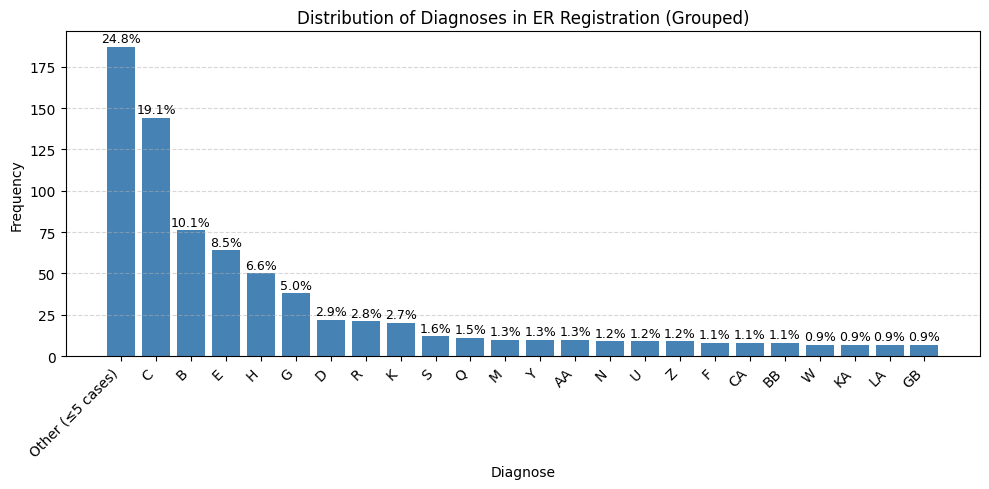

In [16]:
diagnose_counter = Counter()

for trace in log:
    for event in trace:
        if event.get("concept:name") == "ER Registration" and "Diagnose" in event:
            diagnose_counter[event["Diagnose"]] += 1


print(f"There are {len(diagnose_counter)} Unique values of 'Diagnose' in ER Registration events:")
print(sorted(diagnose_counter.keys()))

grouped_counter = Counter()
other_count = 0

for key, count in diagnose_counter.items():
    if count <= 5:
        other_count += count
    else:
        grouped_counter[key] = count

if other_count > 0:
    grouped_counter["Other (≤5 cases)"] = other_count

# Step 3: Prepare for plotting
labels, values = zip(*sorted(grouped_counter.items(), key=lambda x: x[1], reverse=True))
total = sum(values)
percentages = [v / total * 100 for v in values]

# Step 4: Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='steelblue')

# Add percentage labels
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{pct:.1f}%", ha='center', va='bottom', fontsize=9)

plt.title("Distribution of Diagnoses in ER Registration (Grouped)")
plt.xlabel("Diagnose")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Other events

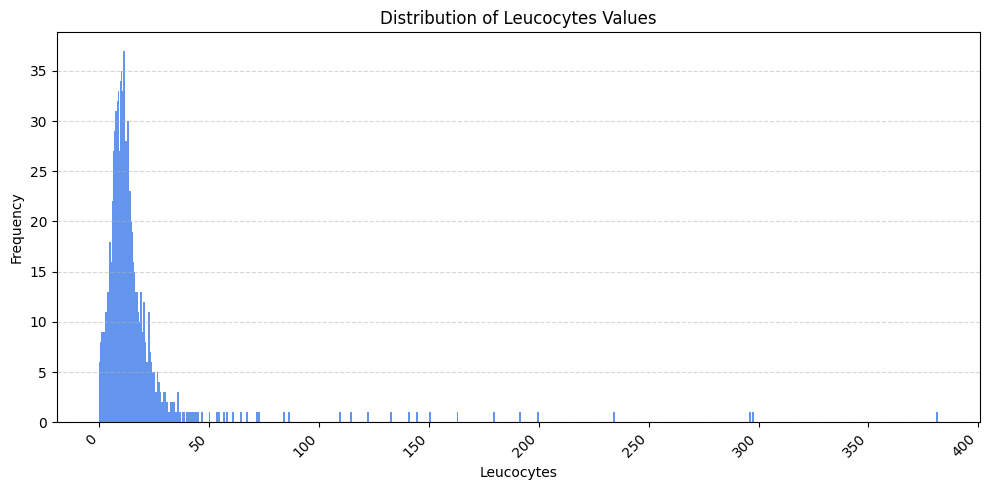

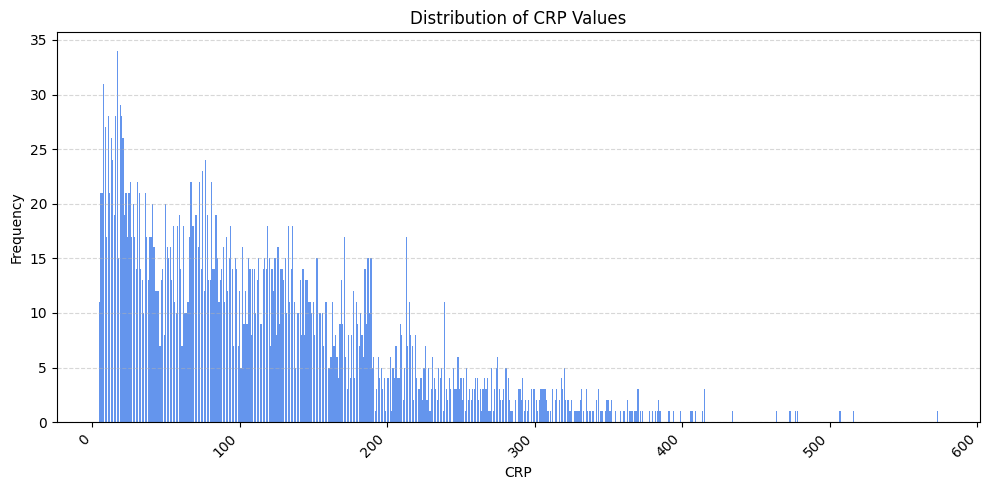

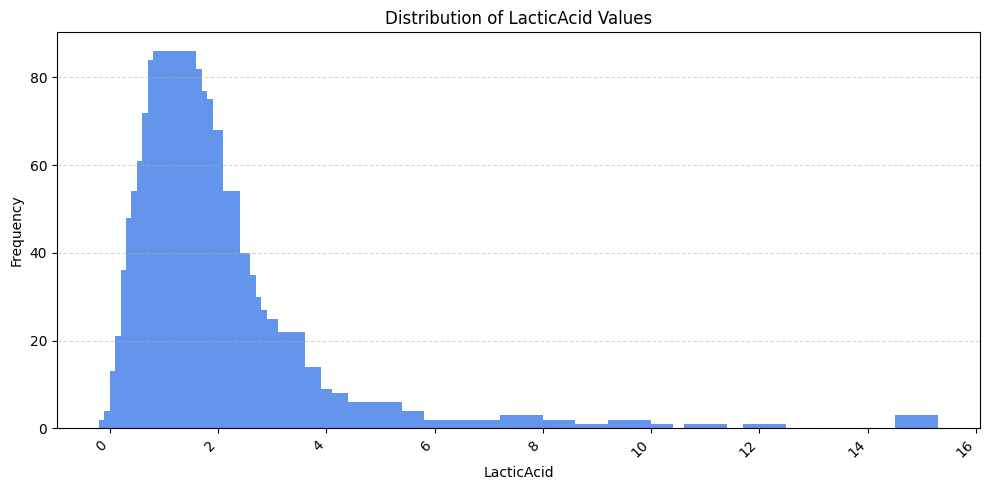

Unique value counts for lab measurements:
  - CRP: 371 unique values in range [5.0, 573.0]
  - LacticAcid: 79 unique values in range [0.2, 14.9]
  - Leucocytes: 360 unique values in range [0.2, 381.3]


In [17]:
# Step 1: Collect lab measurement values only
lab_events = {"Leucocytes", "CRP", "LacticAcid"}
lab_values = defaultdict(Counter)

for trace in log:
    for event in trace:
        if event.get("concept:name") in lab_events:
            for key, value in event.items():
                if key in lab_events:  # Only collect the actual lab result, not metadata
                    lab_values[key][value] += 1

# Step 2: Plotting function
def plot_attr_distribution(attr_name, counter):
    if len(counter) <= 1:
        return  # Skip if no variation

    labels, counts = zip(*sorted(counter.items(), key=lambda x: x[0]))  # sort by value, not count

    plt.figure(figsize=(10, 5))
    bars = plt.bar(labels, counts, color='cornflowerblue')
    plt.title(f"Distribution of {attr_name} Values")
    plt.xlabel(attr_name)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Step 3: Plot
attribute_summary = {}

for attr, counter in lab_values.items():
    attribute_summary[attr] = len(counter)
    if len(counter) > 1:
        plot_attr_distribution(attr, counter)

print("Unique value counts for lab measurements:")
for attr, counter in sorted(lab_values.items()):
    values = list(counter.keys())
    if all(isinstance(v, (int, float)) for v in values):  # only apply range to numeric values
        val_range = f"in range [{min(values)}, {max(values)}]"
    else:
        val_range = ""
    print(f"  - {attr}: {len(values)} unique values {val_range}")

# 🔍 Process-Focused Questions

 1. What are the most common treatment pathways?

In [18]:
trace_stats = case_statistics.get_variant_statistics(log)
trace_stats = sorted(trace_stats, key=lambda x: x['count'], reverse=True)

print("Top 5 most common treatment paths:")
for variant in trace_stats[:5]:
    print(f"{variant['variant']} - Count: {variant['count']}")

Top 5 most common treatment paths:
('ER Registration', 'ER Triage', 'ER Sepsis Triage') - Count: 35
('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP') - Count: 24
('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'CRP', 'Leucocytes') - Count: 22
('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'CRP', 'LacticAcid', 'Leucocytes', 'IV Liquid', 'IV Antibiotics') - Count: 13
('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid') - Count: 11


 2. How much variation exists between different patient journeys?

 Let's analyze the number of unique variants and compare their frequencies.

Top 10 most frequent variants:
1. Count: 35, Path: ('ER Registration', 'ER Triage', 'ER Sepsis Triage')
2. Count: 24, Path: ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP')
3. Count: 22, Path: ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'CRP', 'Leucocytes')
4. Count: 13, Path: ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'CRP', 'LacticAcid', 'Leucocytes', 'IV Liquid', 'IV Antibiotics')
5. Count: 11, Path: ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid')
6. Count: 9, Path: ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Liquid', 'IV Antibiotics')
7. Count: 7, Path: ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'LacticAcid', 'CRP', 'IV Liquid', 'IV Antibiotics')
8. Count: 5, Path: ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'Admission NC', 'Release A')
9. Count: 5, Path: ('ER Registration', 'ER Triage', 'ER Sepsis 

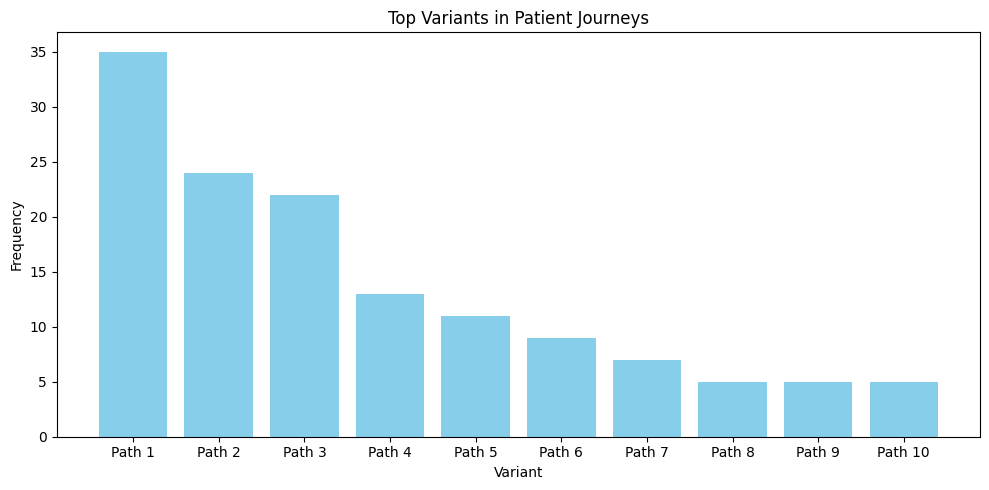


Total unique patient journey variants: 845


In [19]:
# Get all distinct variants and their frequencies
variants_count = case_statistics.get_variant_statistics(log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)

# Display top N variants
top_n = 10
print(f"Top {top_n} most frequent variants:")
for i, variant in enumerate(variants_count[:top_n]):
    print(f"{i+1}. Count: {variant['count']}, Path: {variant['variant']}")

# Plot a bar chart of the top N variants
variant_labels = [f"Path {i+1}" for i in range(top_n)]
variant_counts = [v["count"] for v in variants_count[:top_n]]

plt.figure(figsize=(10, 5))
plt.bar(variant_labels, variant_counts, color='skyblue')
plt.title("Top Variants in Patient Journeys")
plt.xlabel("Variant")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Optional: Show total number of unique variants
print(f"\nTotal unique patient journey variants: {len(variants_count)}")

In [20]:
precent_unique_paths = len(variants_count)*100/len(log)
print(f"Precent of unique pathways: {precent_unique_paths:.2f}%")

Precent of unique pathways: 80.48%


📌 What This Means:

*   Over 80% of the patients follow a path no one else exactly followed.
*   There is very high variability in the patient journeys.
*    Even if complete paths are mostly unique, many traces may share common building blocks (sub-paths).






# ⏱️ Time and Duration Questions

1.	What is the average duration of a case? What’s the range?
→ Let's summarize case durations with min/mean/median/max and plot distributions.

Median duration: 128.24 hours
Average duration: 683.26 hours
Shortest duration: 0.03 hours
Longest duration: 10135.77 hours


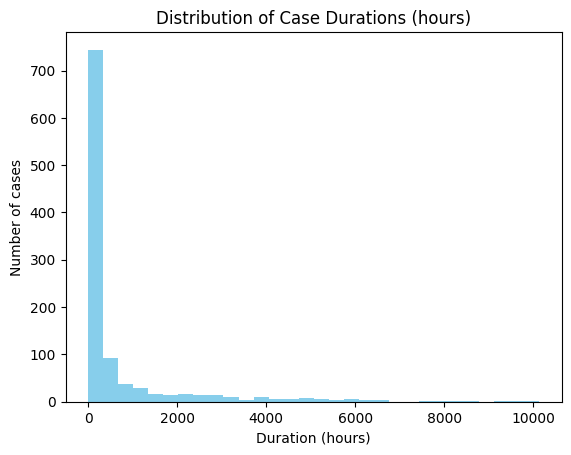

In [35]:
durations = case_statistics.get_all_case_durations(log, parameters={"format": "timedelta"})
dur_hours = [d / 3600 for d in durations]

median_duration = statistics.median(dur_hours)
mean_duration = statistics.mean(dur_hours)
min_duration = min(dur_hours)
max_duration = max(dur_hours)

print(f"Median duration: {median_duration:.2f} hours")
print(f"Average duration: {mean_duration:.2f} hours")
print(f"Shortest duration: {min_duration:.2f} hours")
print(f"Longest duration: {max_duration:.2f} hours")

plt.hist(dur_hours, bins=30, color='skyblue')
plt.title("Distribution of Case Durations (hours)")
plt.xlabel("Duration (hours)")
plt.ylabel("Number of cases")
plt.show()

The wide variation in case durations reveals opportunities for both operational improvement and patient care optimization. While most sepsis cases resolve within 5 days (median ~128 hours), the significantly higher average of ~28 days highlights a subset of long-stay patients that heavily impact resource use. These extended cases may indicate process inefficiencies, late interventions, or complications that warrant further investigation. The hospital could:


*  Identify and analyze long-stay cases to uncover systemic delays, missed escalation opportunities, or care bottlenecks.


*   Benchmark typical treatment duration to define expected recovery timelines and monitor deviations in real time.

*   Prioritize early intervention strategies (e.g., rapid diagnostics, antibiotic delivery) to reduce avoidable extensions of care.

*   Use duration patterns to optimize bed management and ICU planning, especially for peak sepsis admission periods.

2.	What are the average durations between 2 consequent events?

→ Let's analyze transition durations with min/mean/median/max.

In [40]:
concept_name_dict = dict()
new_parralel = True
connected_concept_name = []

for trace_test in log:
  for i in range(len(trace_test) - 1):
      time_diff = trace_test[i + 1]['time:timestamp'] - trace_test[i]['time:timestamp']
      time_diff_minutes = time_diff.total_seconds() / 60  # Convert to minutes
      concept_name = trace_test[i]['concept:name']
      if time_diff_minutes == 0.0:
        if new_parralel:
          connected_concept_name = [concept_name]
          new_parralel = False

        else:
          connected_concept_name.append(concept_name)

      else:
        if not new_parralel:
          connected_concept_name.append(concept_name)
          concept_name = tuple(sorted(connected_concept_name))
          new_parralel = True
        if concept_name not in concept_name_dict:
          concept_name_dict[concept_name] = [time_diff_minutes]
        else:
          concept_name_dict[concept_name].append(time_diff_minutes)

statiasic = dict()


for key in concept_name_dict:
    statiasic[key] = {
          'Avg': sum(concept_name_dict[key]) / len(concept_name_dict[key]),
          'Min': min(concept_name_dict[key]),
          'Max': max(concept_name_dict[key]),
          'Median': statistics.median(concept_name_dict[key]),
          'Count': len(concept_name_dict[key])
      }

events_statsic = pd.DataFrame(statiasic).T
events_statsic = events_statsic.sort_values(by=['Avg'], ascending=False)
events_statsic = events_statsic.round(2)
events_statsic

Avg        Min  \
Release E                                           162368.33  162368.33   
Release A                                           117717.98      71.00   
Release C                                            98113.62    1879.55   
Release D                                            80062.77    1708.83   
CRP                                                   2825.32       0.08   
(CRP, Leucocytes)                                     2597.64       0.25   
Admission NC                                          2066.53       0.45   
(CRP, LacticAcid)                                     2029.17     280.00   
Leucocytes                                            1769.66       1.05   
(Admission NC, CRP)                                   1080.00    1080.00   
(Admission NC, CRP, Leucocytes)                       1080.00    1080.00   
LacticAcid                                             669.94       3.18   
(LacticAcid, Leucocytes)                               661.32     150.40   
(CRP, LacticAcid, Leucocytes)                          485.71       0.02   
(CRP, LacticAcid, Leucocytes, Leucocytes)              340.07     340.07   
Admission IC                                           308.50       0.52   
(ER Triage, Leucocytes)                                195.12     195.12   
(CRP, IV Antibiotics, LacticAcid, Leucocytes)          141.65     141.65   
IV Antibiotics                                         102.95       0.02   
(IV Antibiotics, IV Liquid)                            100.64       0.22   
IV Liquid                                               68.14       0.02   
(Admission IC, CRP, LacticAcid, Leucocytes)             21.00      21.00   
ER Sepsis Triage                                        19.91       0.10   
Return ER                                               18.62      13.72   
Release B                                               13.50      13.50   
(CRP, IV Liquid)                                        13.22      13.22   
(CRP, ER Registration, IV Antibiotics, LacticAcid)      12.07      12.07   
(ER Registration, LacticAcid, Leucocytes)               11.38       2.52   
(ER Registration, Leucocytes)                           10.93       1.90   
ER Registration                                         10.88       0.05   
(CRP, ER Registration, Leucocytes)                       9.31       1.30   
(CRP, ER Registration)                                   8.73       2.42   
ER Triage                                                6.57       0.08   
(ER Registration, IV Antibiotics)                        5.58       5.58   
(CRP, ER Registration, LacticAcid)                       5.14       1.50   
(CRP, IV Liquid, LacticAcid, Leucocytes)                 5.00       5.00   
(IV Liquid, Leucocytes)                                  2.10       2.10   
(ER Sepsis Triage, IV Antibiotics)                       1.10       1.10   

                                                          Max     Median  \
Release E                                           162368.33  162368.33   
Release A                                           600855.30   67705.12   
Release C                                           190077.05  100351.18   
Release D                                           249551.80   30413.89   
CRP                                                  20340.00    2880.00   
(CRP, Leucocytes)                                    27525.00    1800.00   
Admission NC                                         22661.52    1296.36   
(CRP, LacticAcid)                                     4320.00    1440.00   
Leucocytes                                           16852.65    1154.00   
(Admission NC, CRP)                                   1080.00    1080.00   
(Admission NC, CRP, Leucocytes)                       1080.00    1080.00   
LacticAcid                                            5880.00     477.08   
(LacticAcid, Leucocytes)                              2880.00     447.50   
(CRP, LacticAcid, Leucocytes)

the hospital can compare these measured durations to medical or operational benchmarks — such as expected turnaround times for lab results or typical processing times for patient checklists.

Now let's check if we can idenify groups that cause more delay than others.

In [50]:
concept_name_dict = defaultdict(lambda: defaultdict(list))  # Nested defaultdict

for trace_test in log:
    new_parralel = True
    connected_concept_name = []
    for i in range(len(trace_test) - 1):
        org_group = trace_test[i].get('org:group', 'Unknown')  # Get org:group

        time_diff = trace_test[i + 1]['time:timestamp'] - trace_test[i]['time:timestamp']
        time_diff_minutes = time_diff.total_seconds() / 60
        concept_name = trace_test[i]['concept:name']

        if time_diff_minutes == 0.0:
            if new_parralel:
                connected_concept_name = [concept_name]
                new_parralel = False
            else:
                connected_concept_name.append(concept_name)
        else:
            if not new_parralel:
                connected_concept_name.append(concept_name)

                # Calculate statistics for all combinations of 2 parallel events
                for j in range(len(connected_concept_name)):
                    for k in range(j + 1, len(connected_concept_name)):
                        event_pair = tuple(sorted([connected_concept_name[j], connected_concept_name[k]]))
                        if event_pair not in concept_name_dict[org_group]:  # Store by org:group
                            concept_name_dict[org_group][event_pair] = [time_diff_minutes]
                        else:
                            concept_name_dict[org_group][event_pair].append(time_diff_minutes)

                # Calculate statistics for the entire group of parallel events
                concept_name = tuple(sorted(connected_concept_name))

                new_parralel = True

            if concept_name not in concept_name_dict[org_group]:  # Store by org:group
                concept_name_dict[org_group][concept_name] = [time_diff_minutes]
            else:
                concept_name_dict[org_group][concept_name].append(time_diff_minutes)

statiasic = defaultdict(dict)

for org_group, event_data in concept_name_dict.items():
    for key in event_data:
        statiasic[org_group][key] = {
            'avg': sum(event_data[key]) / len(event_data[key]),
            'min': min(event_data[key]),
            'max': max(event_data[key]),
            'median': sorted(event_data[key])[len(event_data[key]) // 2],
            'count': len(event_data[key])
        }

# Convert the nested dictionary to a list of dictionaries
data = []
for org_group, event_stats in statiasic.items():
    for event_name, stats in event_stats.items():
        data.append({
            'org:group': org_group,
            'Event': event_name,
            'Avg': stats['avg'],
            'Min': stats['min'],
            'Max': stats['max'],
            'Median': stats['median'],
            'Count': stats['count']
        })

# Create the DataFrame
event_by_groups = pd.DataFrame(data)
event_by_groups = event_by_groups.round(2)
event_by_groups = event_by_groups.sort_values(by=['Avg'], ascending=False)
event_by_groups

org:group                                     Event        Avg        Min  \
34         E                                 Release E  162368.33  162368.33   
32         E                                 Release A  117717.98      71.00   
35         E                                 Release C   98113.62    1879.55   
33         E                                 Release D   80062.77    1708.83   
46         M                              Admission NC    3044.16      15.42   
..       ...                                       ...        ...        ...   
12         A  (CRP, IV Liquid, LacticAcid, Leucocytes)       5.00       5.00   
11         A                          (CRP, IV Liquid)       5.00       5.00   
10         A                   (IV Liquid, Leucocytes)       5.00       5.00   
66         X                              Admission NC       4.72       4.72   
5          A        (ER Sepsis Triage, IV Antibiotics)       1.10       1.10   

          Max     Median  Count  
34  162368.33  162368.33      1  
32  600855.30   67839.55    278  
35  190077.05  131275.37      6  
33  249551.80   50666.03     10  
46   18390.00    2404.32     84  
..        ...        ...    ...  
12       5.00       5.00      1  
11       5.00       5.00      1  
10       5.00       5.00      1  
66       4.72       4.72      1  
5        1.10       1.10      2  

[69 rows x 7 columns]

In [52]:
top_k = 9  # Change this value to display a different number of top events


# 1. Find the top k events
top_events = events_statsic.sort_values(by=['Avg'], ascending=False).head(top_k).index.unique()
# convert to str
top_events = [str(event) for event in top_events]

# 2. Filter the DataFrame to include only data for the top k events
filtered_df = event_by_groups[event_by_groups['Event'].isin(top_events)]

# 3. Create the bar plot
fig = px.bar(
    filtered_df,
    x="Event",
    y="Avg",
    color="org:group",  # Group by 'org:group'
    barmode="group",  # Display bars side-by-side for each group
    title=f"Average Time of Top {top_k} Events by Group (Sorted Descending)",
)

fig.update_layout(
    xaxis_title="Event",
    yaxis_title="Average Time",
    xaxis={'categoryorder':'total descending'}  # Sort bars in descending order
)

fig.show()

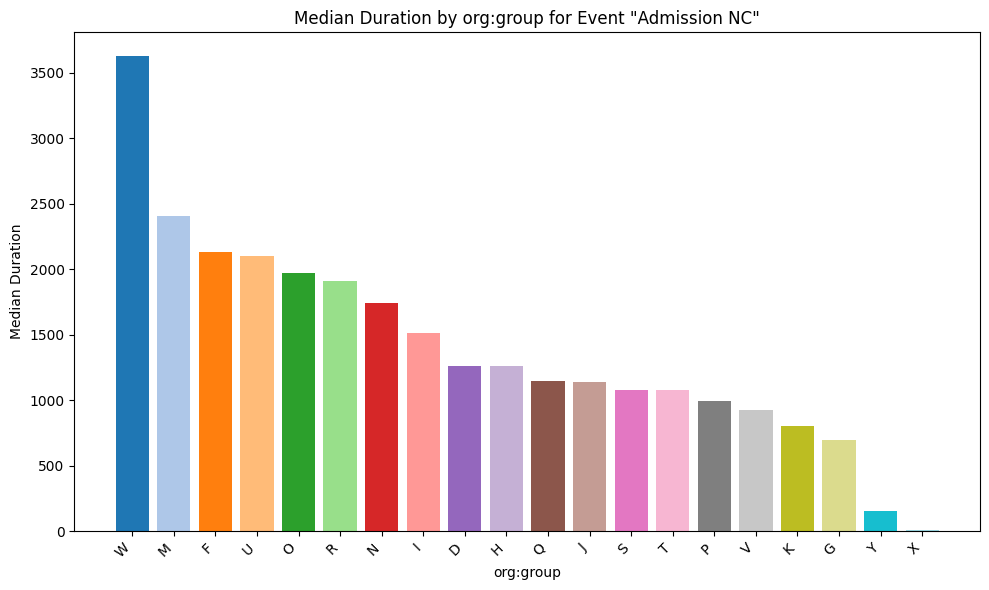

In [57]:
select_event = 'Admission NC'
duration_col = 'Median'

# Filter and sort first
filtered_df = event_by_groups[event_by_groups['Event'] == select_event].sort_values(duration_col, ascending=False)

# Extract groups and durations after sorting
groups = filtered_df['org:group'].tolist()
durations = filtered_df[duration_col].tolist()

cmap = plt.get_cmap('tab20')
colors = [cmap(i % 20) for i in range(len(groups))]

plt.figure(figsize=(10,6))
bars = plt.bar(groups, durations, color=colors)
plt.xlabel('org:group')
plt.ylabel(f'{duration_col} Duration')
plt.title(f'{duration_col} Duration by org:group for Event "{select_event}"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

It is evident that the org group W has a significantly longer median duration compared to other groups when handling admission to the NC. Observing this pattern—both for this and other events—can provide valuable insights to the hospital for making informed decisions regarding staff allocation and targeted training programs.

Now let's look into the time between consecutive events:

In [59]:
# Dictionary to store the time differences between consecutive events
time_diffs = defaultdict(list)

# Iterate through the log to calculate time differences, considering parallel events as one
for trace in log:
    new_parralel = True
    connected_concept_name = []
    for i in range(len(trace) - 1):
        time_diff = trace[i + 1]['time:timestamp'] - trace[i]['time:timestamp']
        time_diff_minutes = time_diff.total_seconds() / 60  # Convert to minutes
        concept_name = trace[i]['concept:name']

        if time_diff_minutes == 0.0:
            if new_parralel:
                connected_concept_name = [concept_name]
                new_parralel = False
            else:
                connected_concept_name.append(concept_name)
        else:  # Time difference greater than 0, events not parallel
            if not new_parralel:  # If there were parallel events, treat them as one
                connected_concept_name.append(concept_name)
                concept_name = tuple(sorted(connected_concept_name))  # Represent parallel events as a tuple
                new_parralel = True

            # Logic for consecutive events
            prev_event = trace[i - 1]['concept:name'] if i > 0 else None  # Get previous event if not the first
            if prev_event is not None:
                event_pair = (prev_event, concept_name)  # Create event pair
                time_diffs[event_pair].append(time_diff_minutes)  # Add time difference to dictionary

# Create a list to store the data for the DataFrame
data = []
for event_pair, diffs in time_diffs.items():
    # find avg, min, max, median and count and save the as columns
    data.append([event_pair[0], event_pair[1], sum(diffs) / len(diffs), min(diffs), max(diffs), sorted(diffs)[len(diffs) // 2], len(diffs)])

# Create the DataFrame
event_pairs = pd.DataFrame(data, columns=['Event1', 'Event2', 'AvgTime', 'MinTime', 'MaxTime', 'MedianTime', 'Count'])
# event_pairs = event_pairs.sort_values(by=['Event1','AvgTime'])
event_pairs = event_pairs.sort_values(by=['AvgTime'],ascending=False)
event_pairs = event_pairs.round(2)
event_pairs

Event1                              Event2    AvgTime  \
75                CRP                           Release E  162368.33   
19                CRP                           Release A  129059.95   
35       Admission NC                           Release A  121119.55   
32         Leucocytes                           Release A  101038.04   
93         Leucocytes                           Release C  100351.18   
..                ...                                 ...        ...   
76   ER Sepsis Triage  (ER Sepsis Triage, IV Antibiotics)       1.10   
105    IV Antibiotics                          Leucocytes       1.05   
97     IV Antibiotics                     ER Registration       0.98   
1          LacticAcid                           ER Triage       0.75   
100      Admission IC                    ER Sepsis Triage       0.62   

       MinTime    MaxTime  MedianTime  Count  
75   162368.33  162368.33   162368.33      1  
19      300.00  600855.30    82124.22    138  
35     2142.57  571688.90    67839.55     43  
32       71.00  597540.25    65877.73     96  
93    69427.00  131275.37   131275.37      2  
..         ...        ...         ...    ...  
76        1.10       1.10        1.10      1  
105       1.05       1.05        1.05      1  
97        0.98       0.98        0.98      1  
1         0.33       1.33        0.62     14  
100       0.62       0.62        0.62      1  

[106 rows x 7 columns]

3. What are the typical bottlenecks or long idle times between steps?

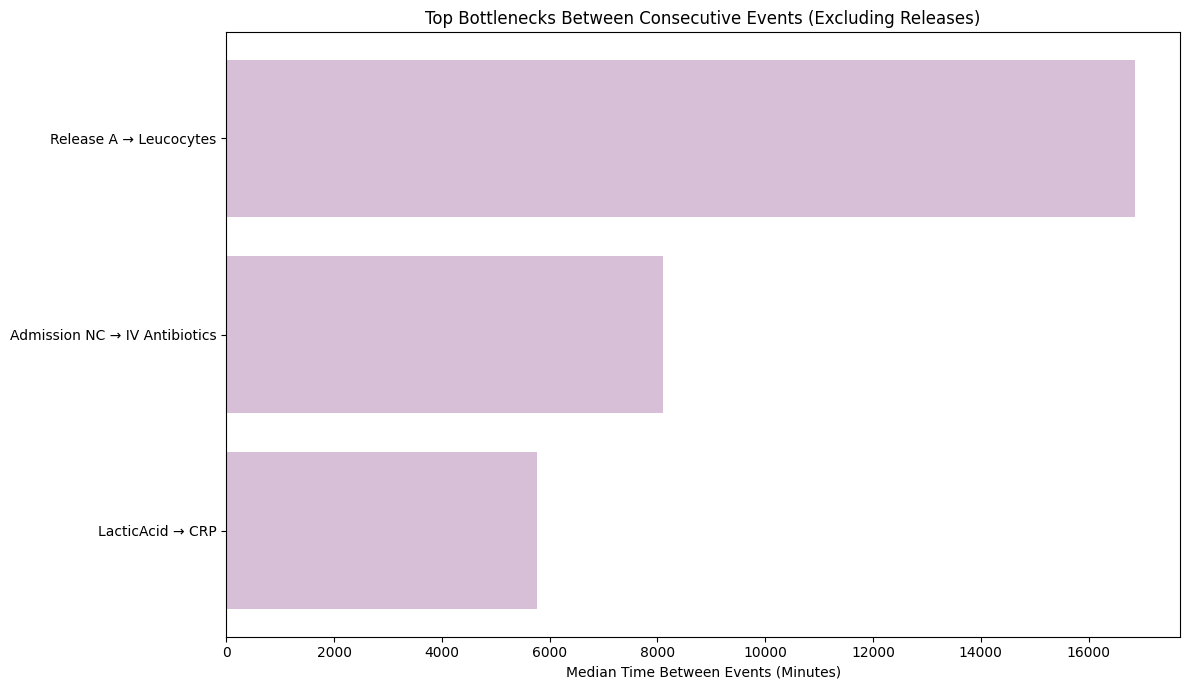

In [69]:
# Filter out pairs where Event2 contains release keywords (case insensitive)
def is_release(event):
    # If it's a string, check if 'release' in it (case-insensitive)
    if isinstance(event, str):
        return 'release' in event.lower()
    return False  # if something else, treat as not release

filtered_df = event_pairs[~event_pairs['Event2'].apply(is_release)]

# Sort by MedianTime descending to highlight slowest pairs (bottlenecks)
filtered_df = filtered_df.sort_values('MedianTime', ascending=False)

# Select top N pairs to visualize, e.g., top 20 bottlenecks
top_n = 3
top_df = filtered_df.head(top_n)

# Create labels combining Event1 and Event2
labels = top_df['Event1'].astype(str) + " → " + top_df['Event2'].astype(str)
durations = top_df['MedianTime']

plt.figure(figsize=(12,7))
bars = plt.barh(labels, durations, color='thistle')
plt.xlabel('Median Time Between Events (Minutes)')
plt.title('Top Bottlenecks Between Consecutive Events (Excluding Releases)')
plt.gca().invert_yaxis()  # Largest at top
plt.tight_layout()
plt.show()

# 💰 Process mining algorithms

## Directly-Follows Graph (DFG)

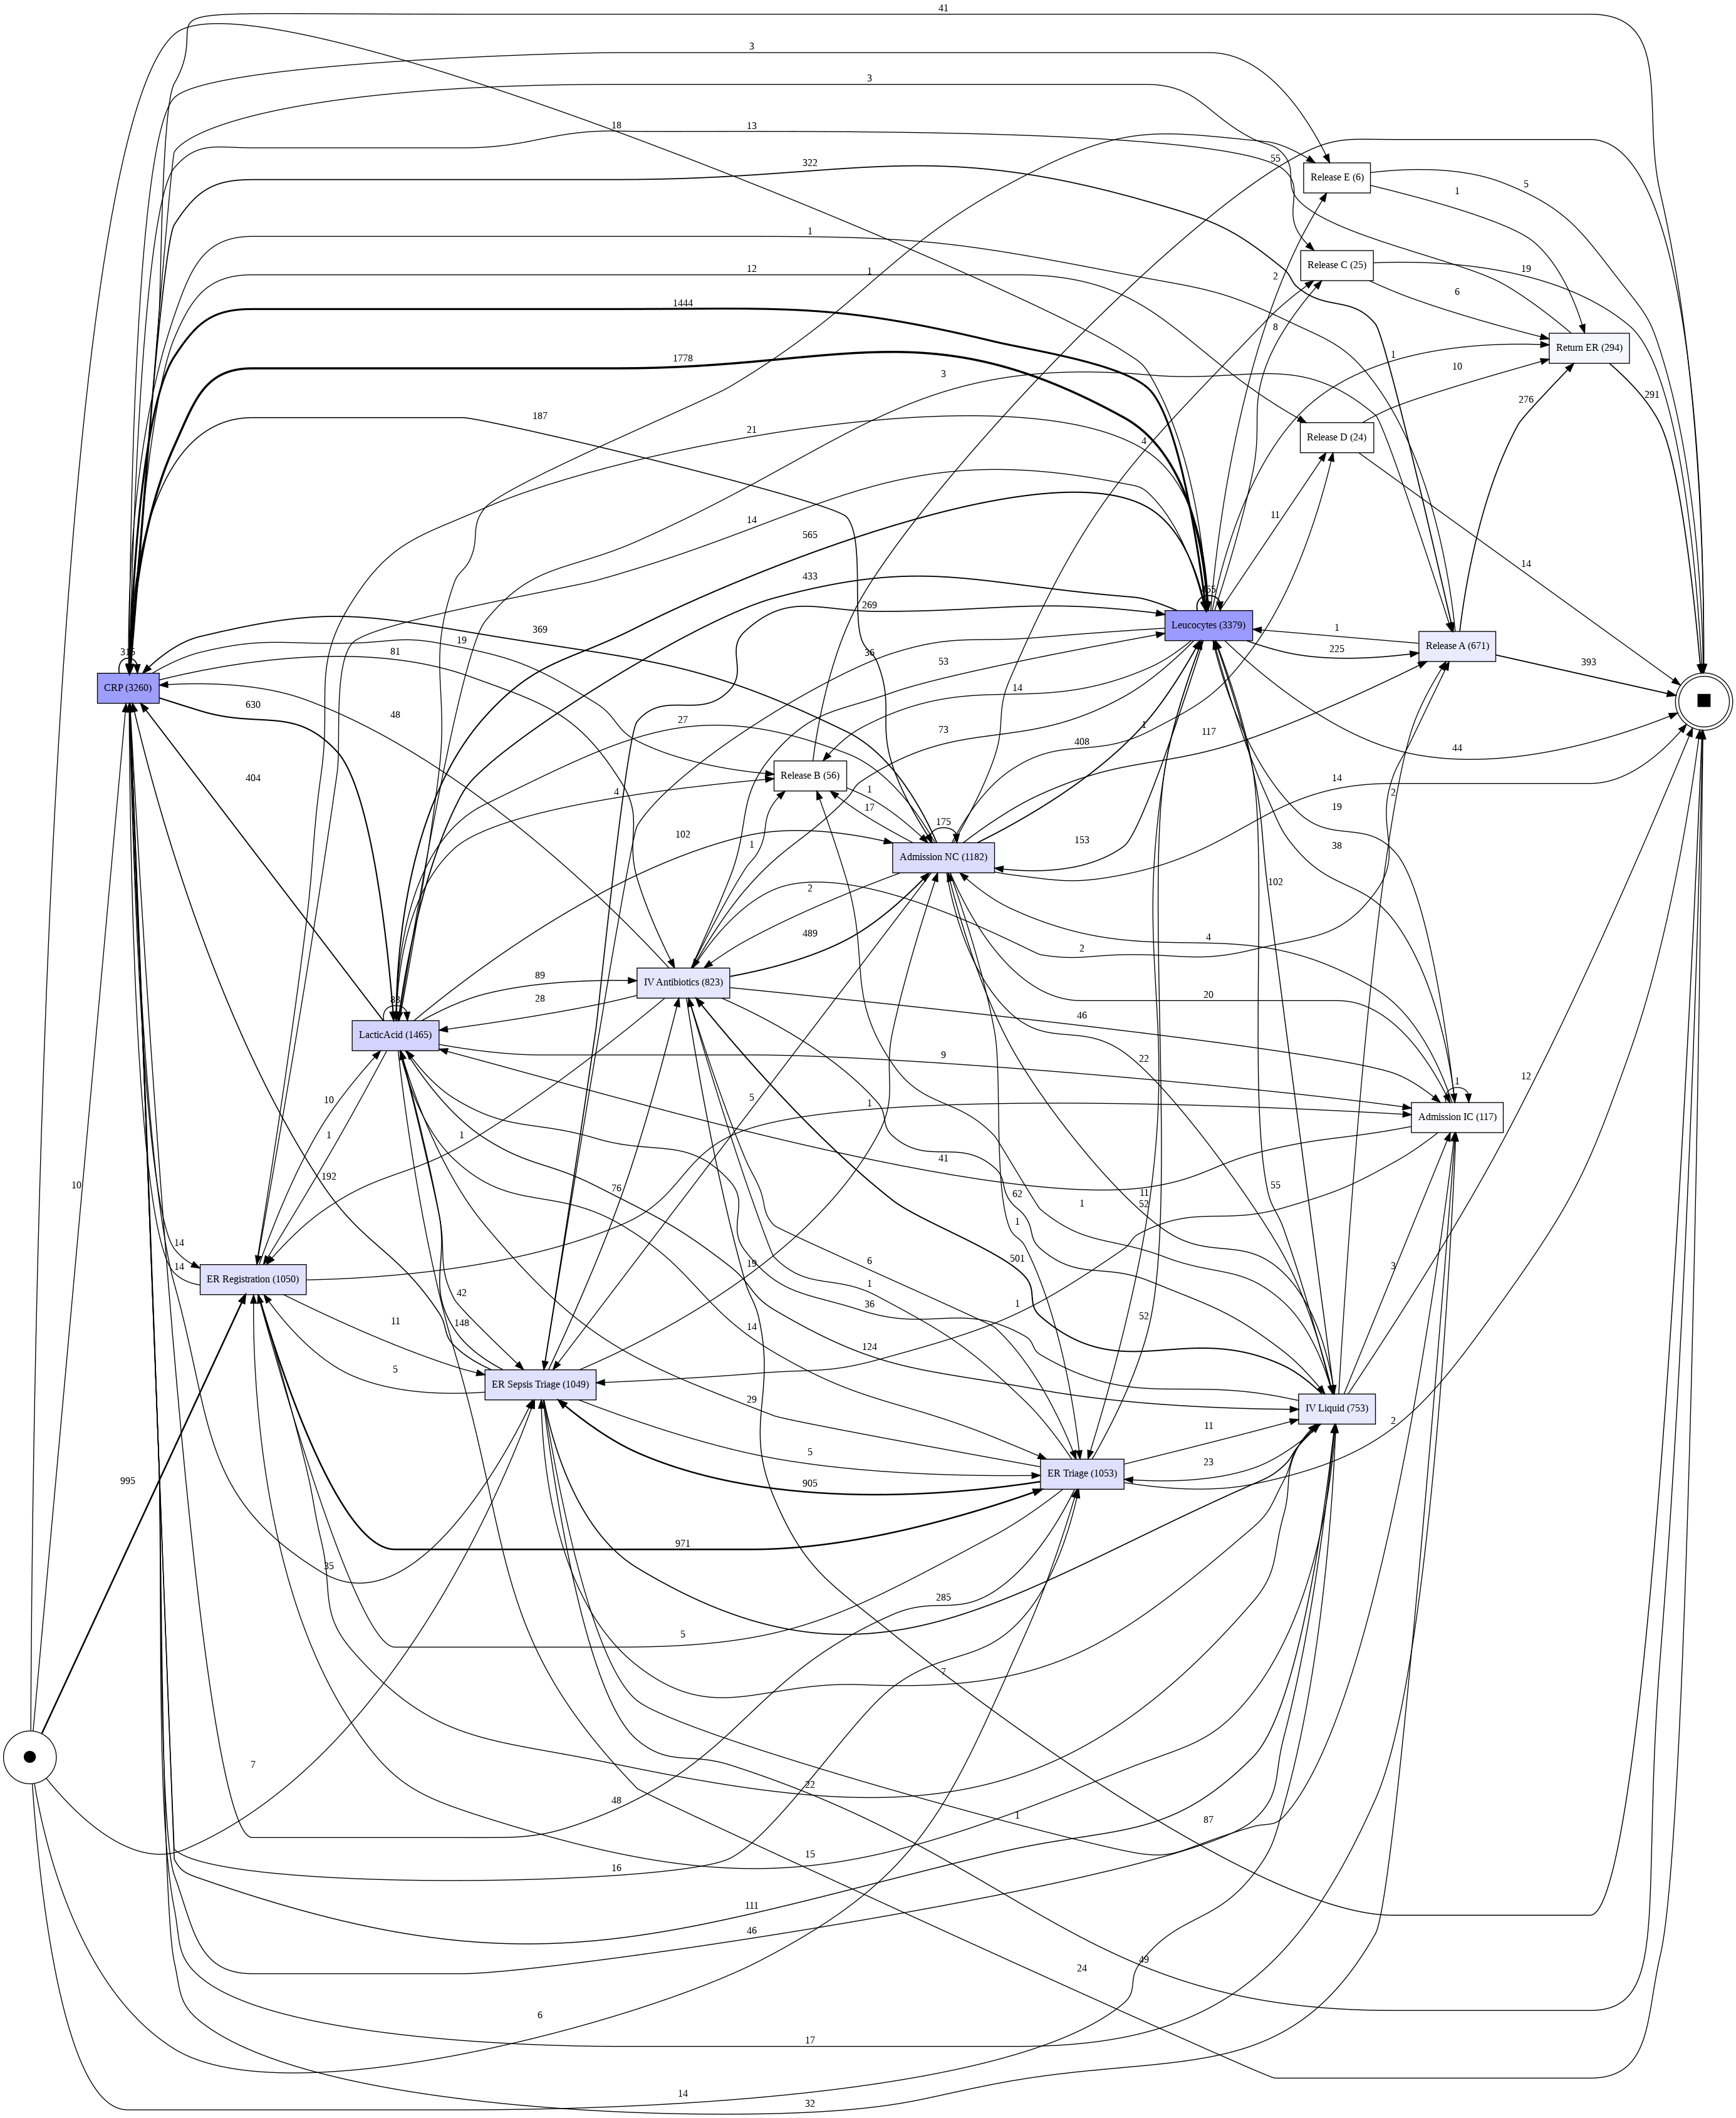

In [38]:
#	dfg: A dictionary where each key (A, B) represents two events, and the value is the number of times event B directly follows event A in the log.
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

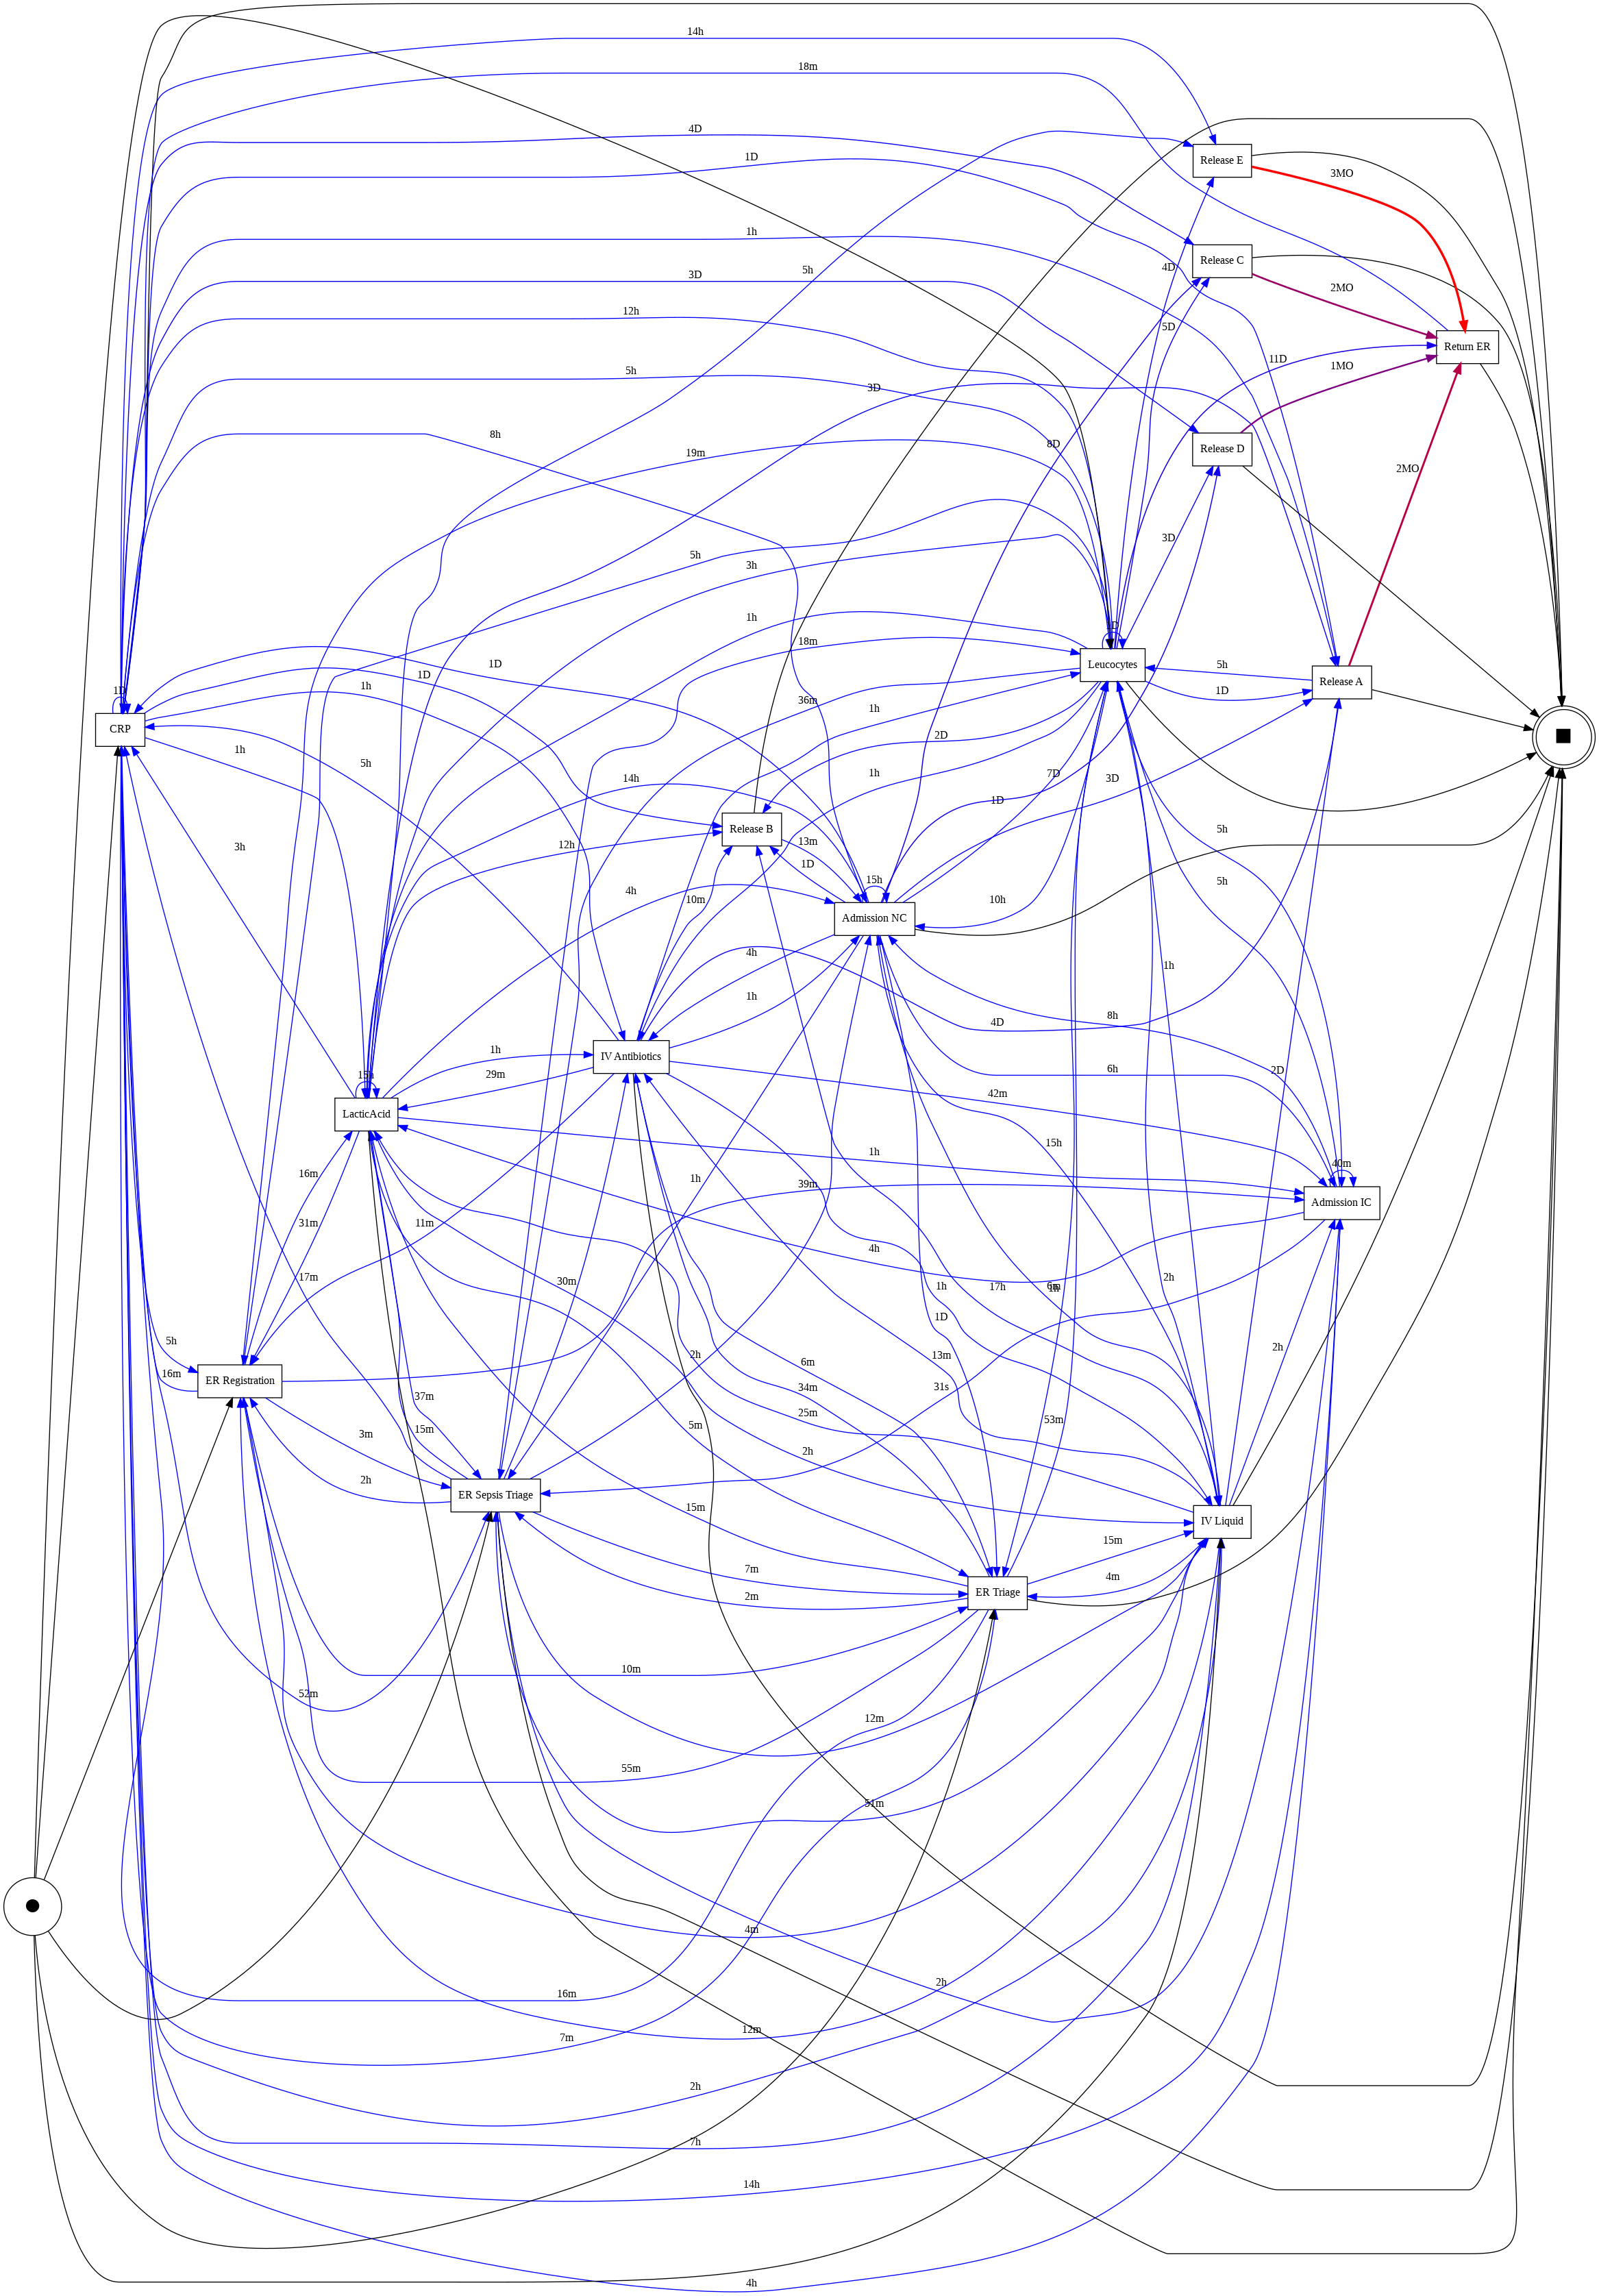

In [39]:
#performance_dfg: A dictionary where each key (A, B) is a transition, but the value is the average time duration between A and B (in hours).
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

## Alpha-miner

In [23]:
footprints = footprints_discovery.apply(log)

# Initialize counters
dfg_counter = Counter()
sequence_counter = Counter()
parallel_counter = Counter()
start_activities = Counter()
end_activities = Counter()

# Loop over all traces' footprints
for fp in footprints:
    dfg_counter.update(fp.get('dfg', {}))
    sequence_counter.update(fp.get('sequence', set()))
    parallel_counter.update(fp.get('parallel', set()))
    start_activities.update(fp.get('start_activities', set()))
    end_activities.update(fp.get('end_activities', set()))

In [25]:
# These should be sets of tuples (a, b)
dfg_pairs = set(dfg_counter.keys())
parallel_pairs = set(parallel_counter.keys())
sequence_pairs = set(sequence_counter.keys())  # optional
activities = sorted(set(a for a, b in dfg_pairs).union(b for a, b in dfg_pairs))
def get_relation(a, b):
    if (a, b) in parallel_pairs and (b, a) in parallel_pairs:
        return '||'
    elif (a, b) in dfg_pairs and (b, a) not in dfg_pairs:
        return '→'
    elif (a, b) not in dfg_pairs and (b, a) in dfg_pairs:
        return '←'
    elif (a, b) not in dfg_pairs and (b, a) not in dfg_pairs and (a, b) not in parallel_pairs and (b, a) not in parallel_pairs:
        return '#'
    else:
        return '?'

relation_matrix = pd.DataFrame('', index=activities, columns=activities)

for a in activities:
    for b in activities:
        if a == b:
            relation_matrix.loc[a, b] = '—'  # self-loop or no relation
        else:
            relation_matrix.loc[a, b] = get_relation(a, b)
display(relation_matrix)

Admission IC Admission NC CRP ER Registration  \
Admission IC                —            ?  ||               ←   
Admission NC                ?            —  ||               #   
CRP                        ||           ||   —               ?   
ER Registration             →            #   ?               —   
ER Sepsis Triage            ?           ||   ?               ?   
ER Triage                   #            ←   ?               ?   
IV Antibiotics              →            ?  ||               →   
IV Liquid                   →            ?  ||               ?   
LacticAcid                 ||           ||  ||               ?   
Leucocytes                 ||           ||  ||              ||   
Release A                   #            ←   ?               #   
Release B                   #            ?   ←               #   
Release C                   #            ←   ←               #   
Release D                   #            ←   ←               #   
Release E                   #            #   ←               #   
Return ER                   #            #   →               #   

                 ER Sepsis Triage ER Triage IV Antibiotics IV Liquid  \
Admission IC                    ?         #              ←         ←   
Admission NC                   ||         →              ?         ?   
CRP                             ?         ?             ||        ||   
ER Registration                 ?         ?              ←         ?   
ER Sepsis Triage                —         ?              →         ?   
ER Triage                       ?         —              ?         ?   
IV Antibiotics                  ←         ?              —         ?   
IV Liquid                       ?         ?              ?         —   
LacticAcid                      ?         ?             ||        ||   
Leucocytes                      ?         ?             ||         ?   
Release A                       #         #              ←         ←   
Release B                       #         #              ←         ←   
Release C                       #         #              #         #   
Release D                       #         #              #         #   
Release E                       #         #              #         #   
Return ER                       #         #              #         #   

                 LacticAcid Leucocytes Release A Release B Release C  \
Admission IC             ||         ||         #         #         #   
Admission NC             ||         ||         →         ?         →   
CRP                      ||         ||         ?         →         →   
ER Registration           ?         ||         #         #         #   
ER Sepsis Triage          ?          ?         #         #         #   
ER Triage                 ?          ?         #         #         #   
IV Antibiotics           ||         ||         →         →         #   
IV Liquid                ||          ?         →         →         #   
LacticAcid                —         ||         →         →         #   
Leucocytes               ||          —         ?         →         →   
Release A                 ←          ?         —         #         #   
Release B                 ←          ←         #         —         #   
Release C                 #          ←         #         #         —   
Release D                 #          ←         #         #         #   
Release E                 ←          ←         #         #         #   
Return ER                 #          ←         ←         #         ←   

                 Release D Release E Return ER  
Admission IC             #         #         #  
Admission NC             →         #         #  
CRP                      →         →         ←  
ER Registration          #         #         #  
ER Sepsis Triage         #         #         #  
ER Triage                #         #         #  
IV Antibiotics           #         #         #  
IV Liquid                #         #         #  
Lac

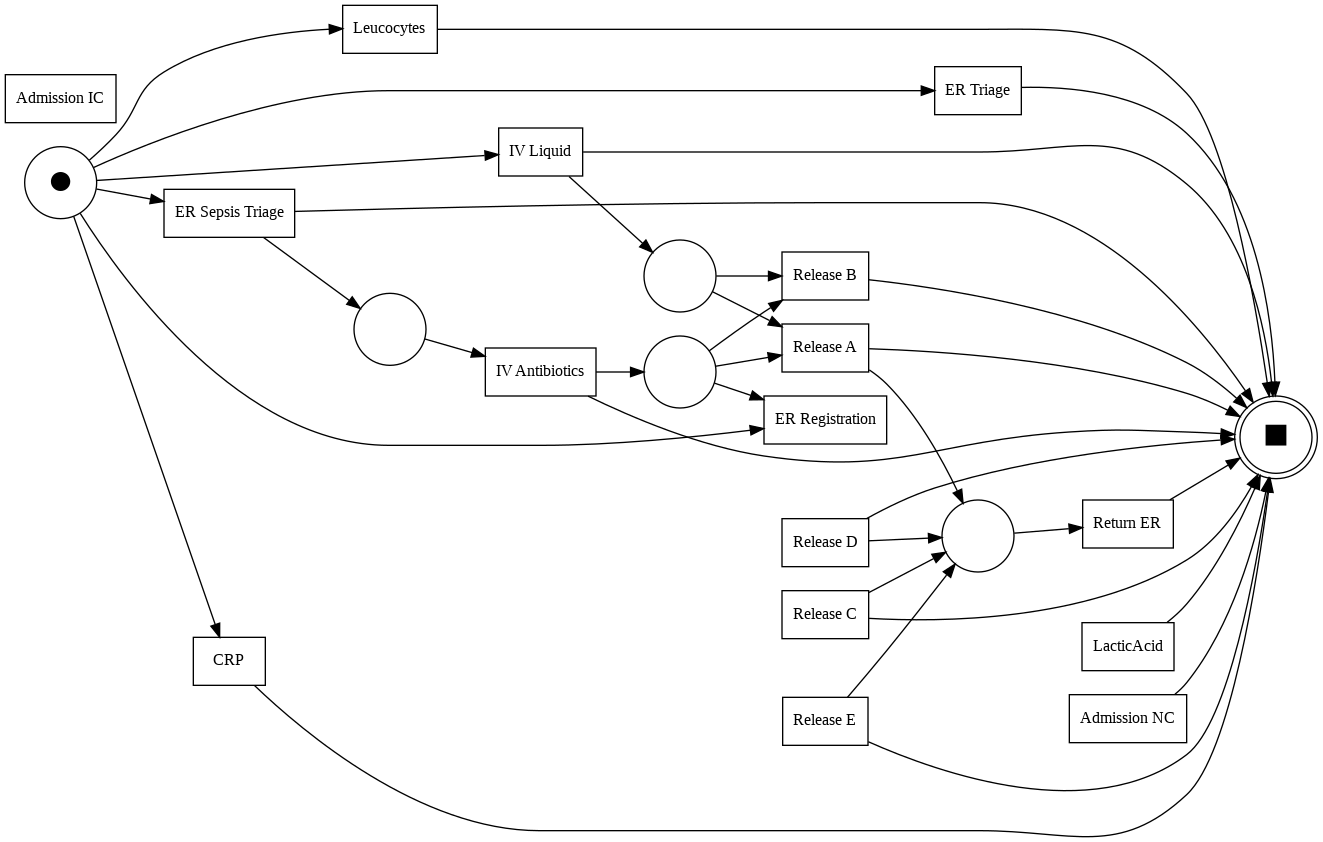

In [26]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
pm4py.view_petri_net(net, initial_marking, final_marking)

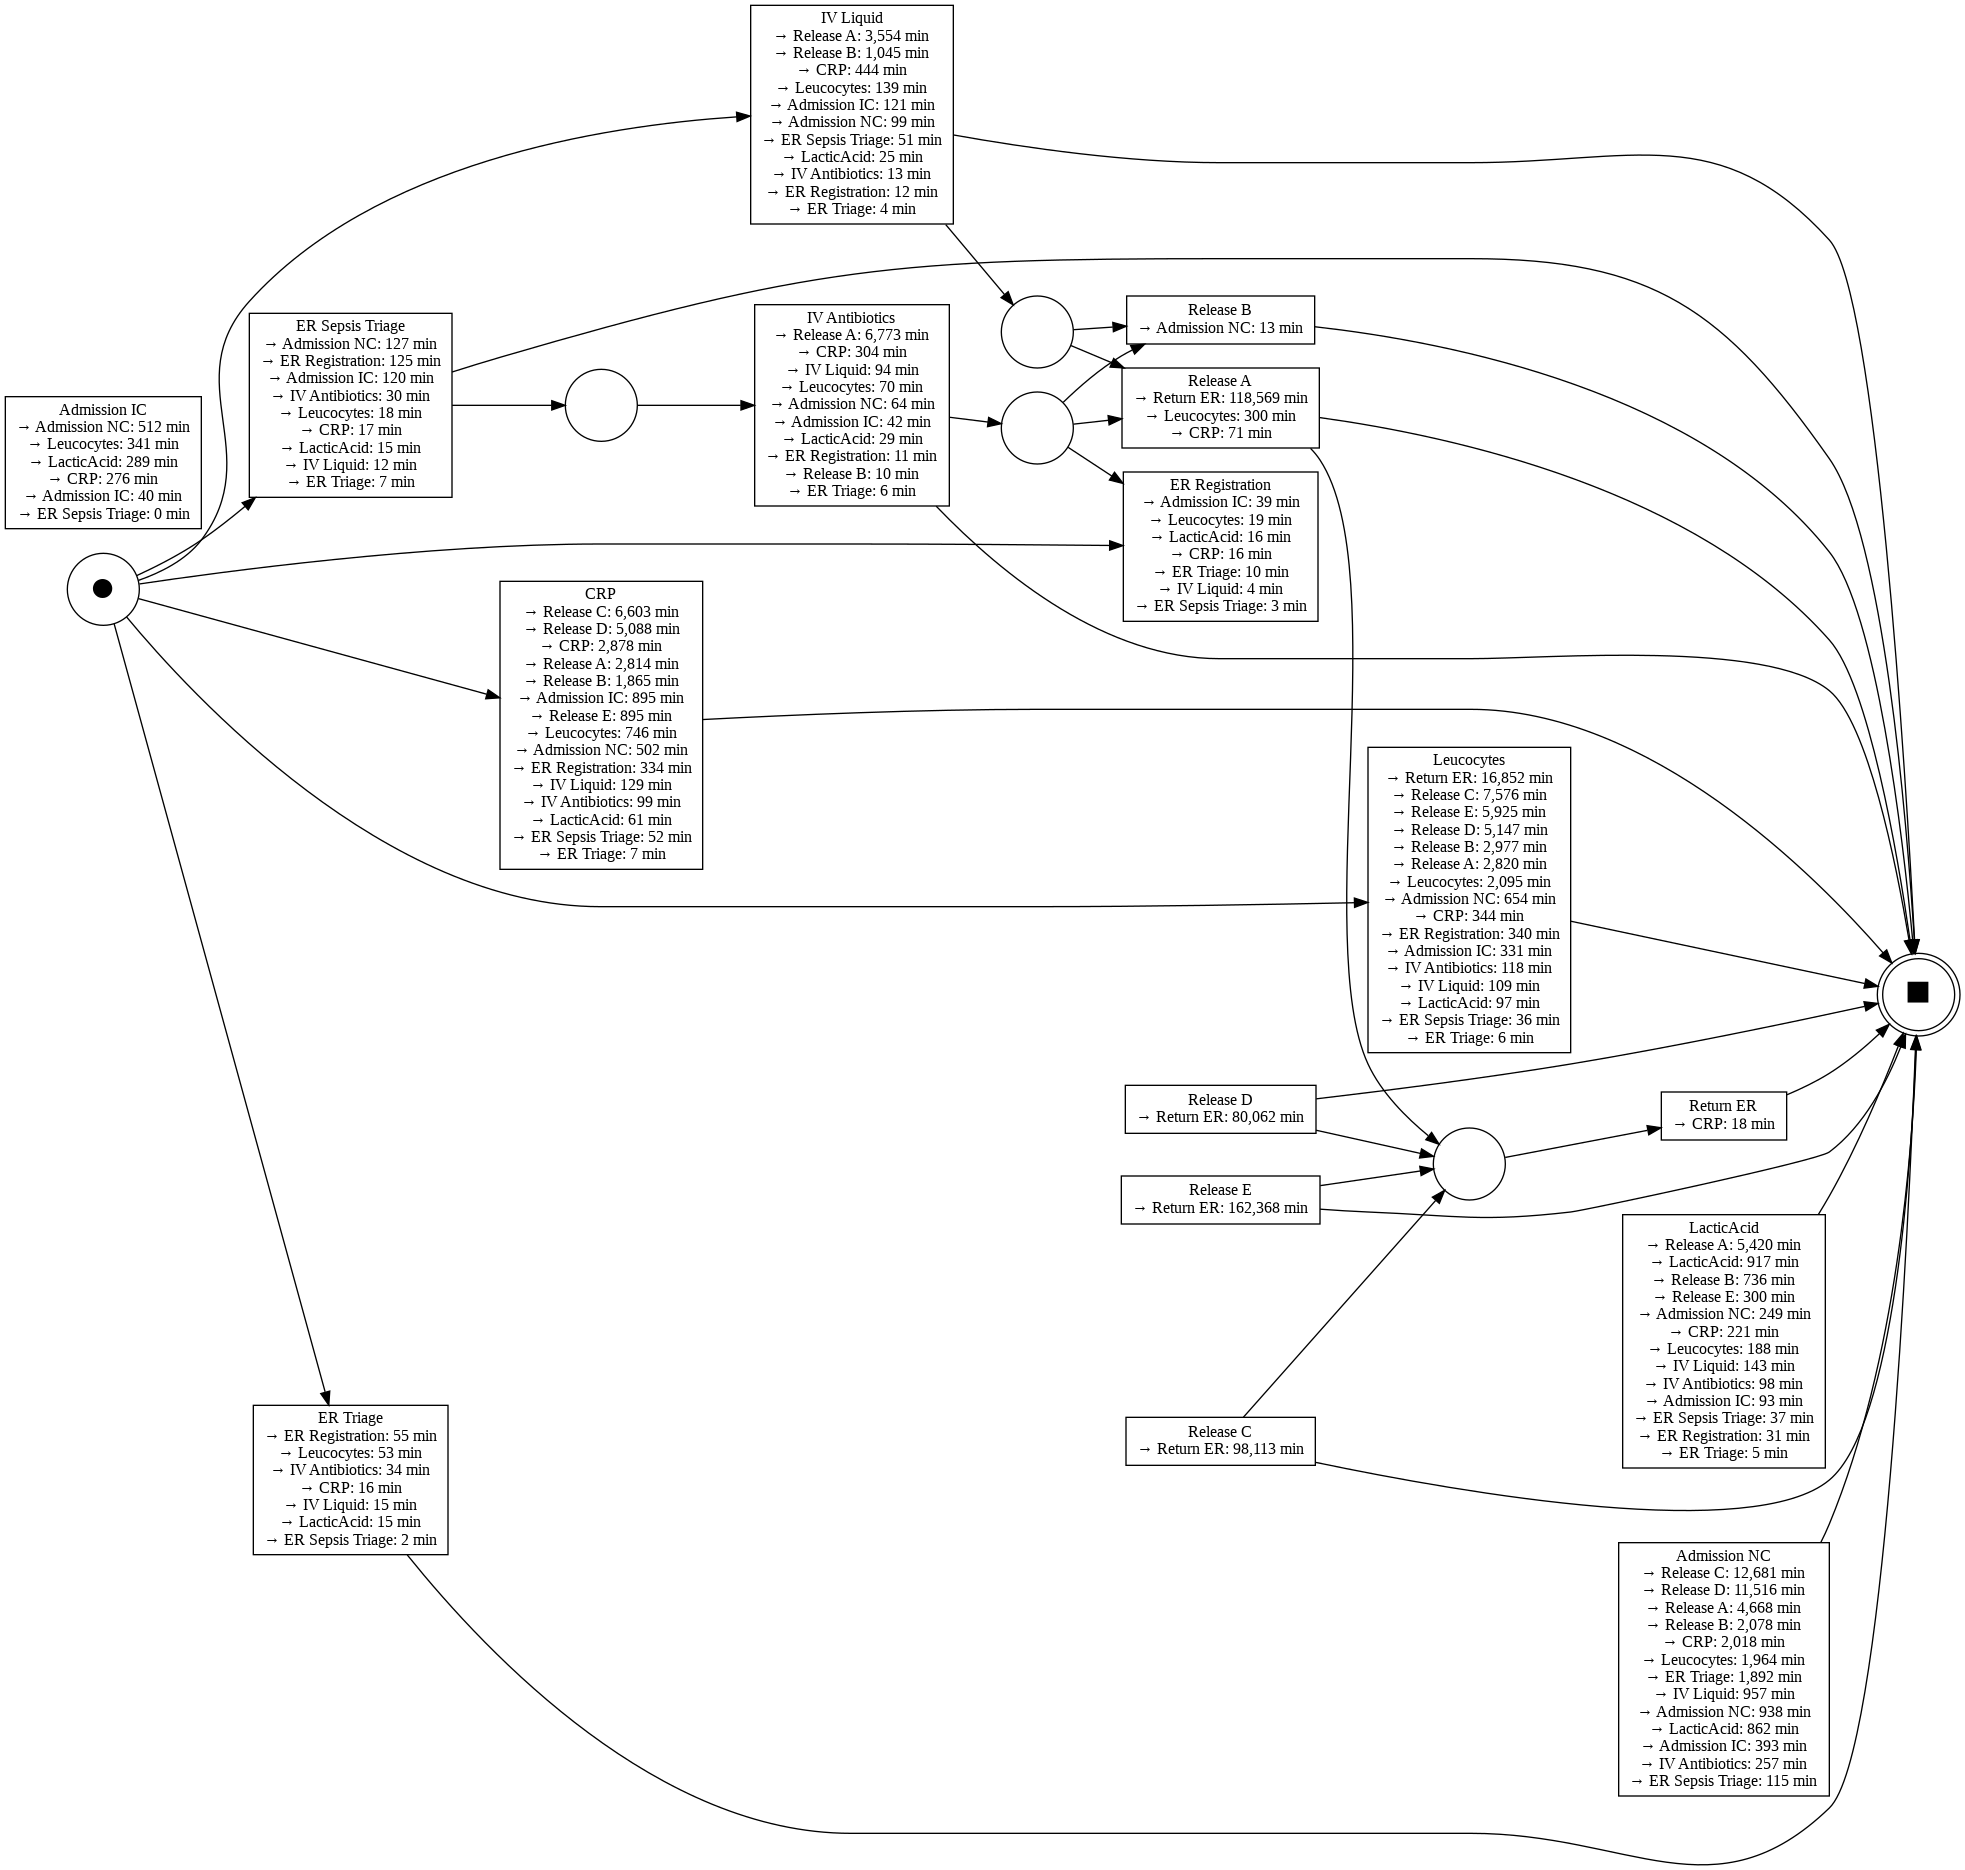

In [80]:
# Discover Petri net
net, im, fm = alpha_miner.apply(log)

# Step 1: Calculate average transition durations
transition_durations = defaultdict(list)

for trace in log:
    for i in range(len(trace) - 1):
        a, b = trace[i], trace[i + 1]
        if "concept:name" in a and "concept:name" in b and "time:timestamp" in a and "time:timestamp" in b:
            delta = (b["time:timestamp"] - a["time:timestamp"]).total_seconds() / 60
            transition_durations[(a["concept:name"], b["concept:name"])].append(delta)

# Step 2: Compute averages and sort by duration descending
avg_durations = {
    k: sum(v) / len(v) for k, v in transition_durations.items() if len(v) > 0
}
sorted_durations = sorted(avg_durations.items(), key=lambda x: x[1], reverse=True)

# Step 3: Annotate Petri net transitions
for t in net.transitions:
    if not t.label:
        continue

    # Find all destination activities from this transition
    matching = [(dst, avg_durations[(t.label, dst)]) for (src, dst) in avg_durations if src == t.label]

    # Sort them by descending duration
    matching = sorted(matching, key=lambda x: x[1], reverse=True)

    if matching:
        annotations = [
            f"→ {dst}: {int(duration):,} min" for dst, duration in matching
        ]
        t.label += "\n" + "\n".join(annotations)

# Step 4: Visualize the annotated Petri net
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

## Inductive miner

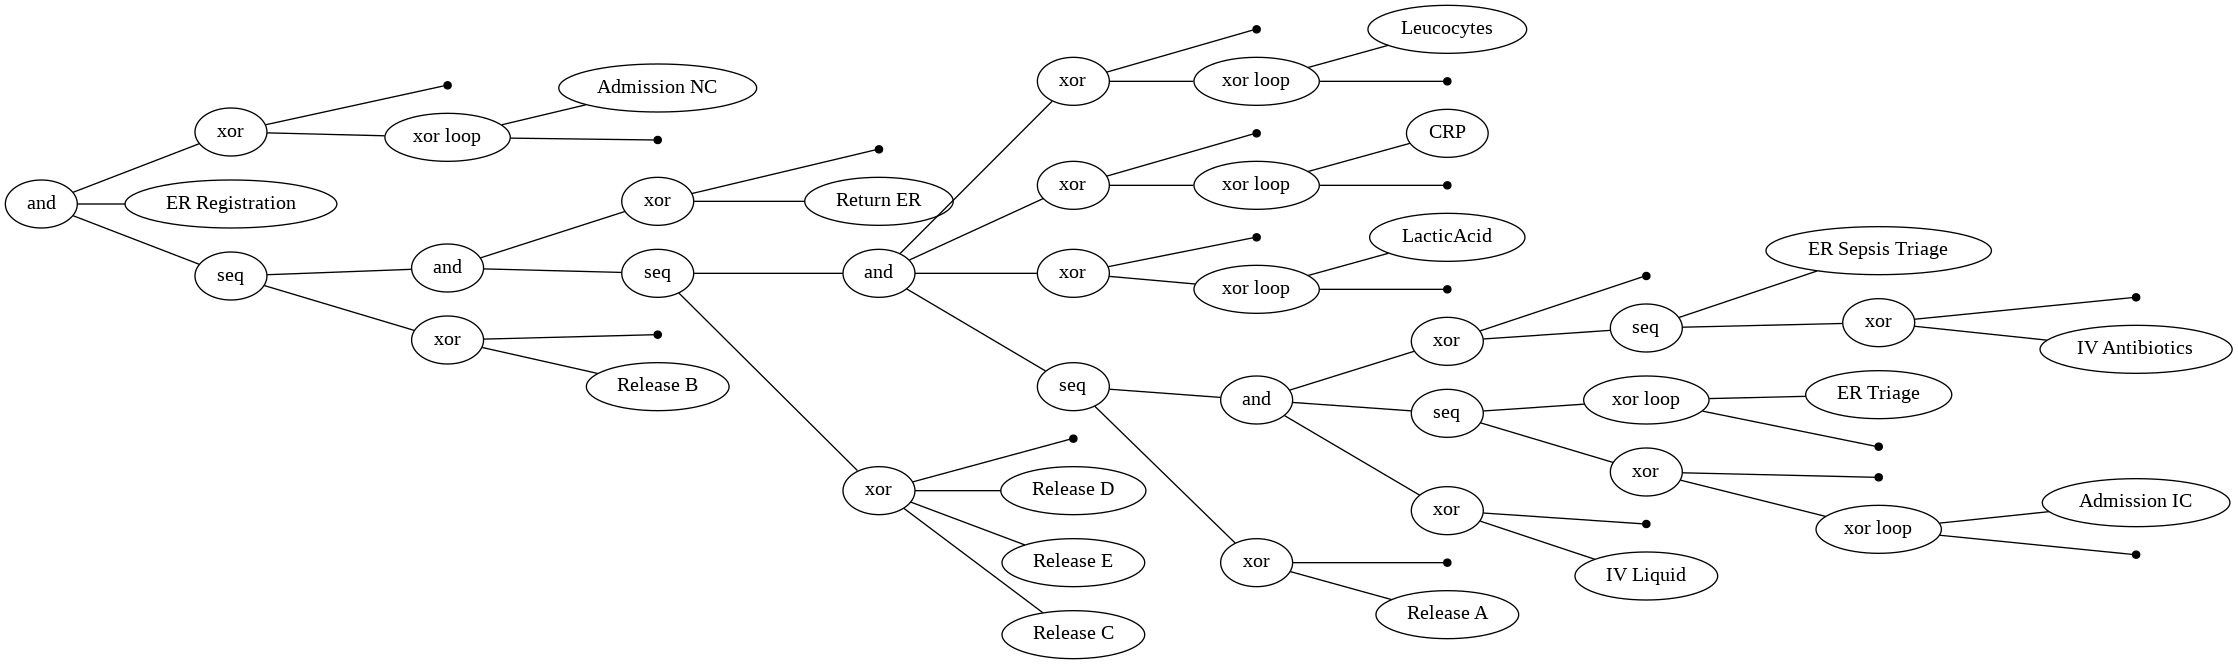

In [33]:
# Discover the process tree from the event log
process_tree = pm4py.discover_process_tree_inductive(log)

# Visualize the process tree
gviz = pt_visualizer.apply(process_tree)
pt_visualizer.view(gviz)

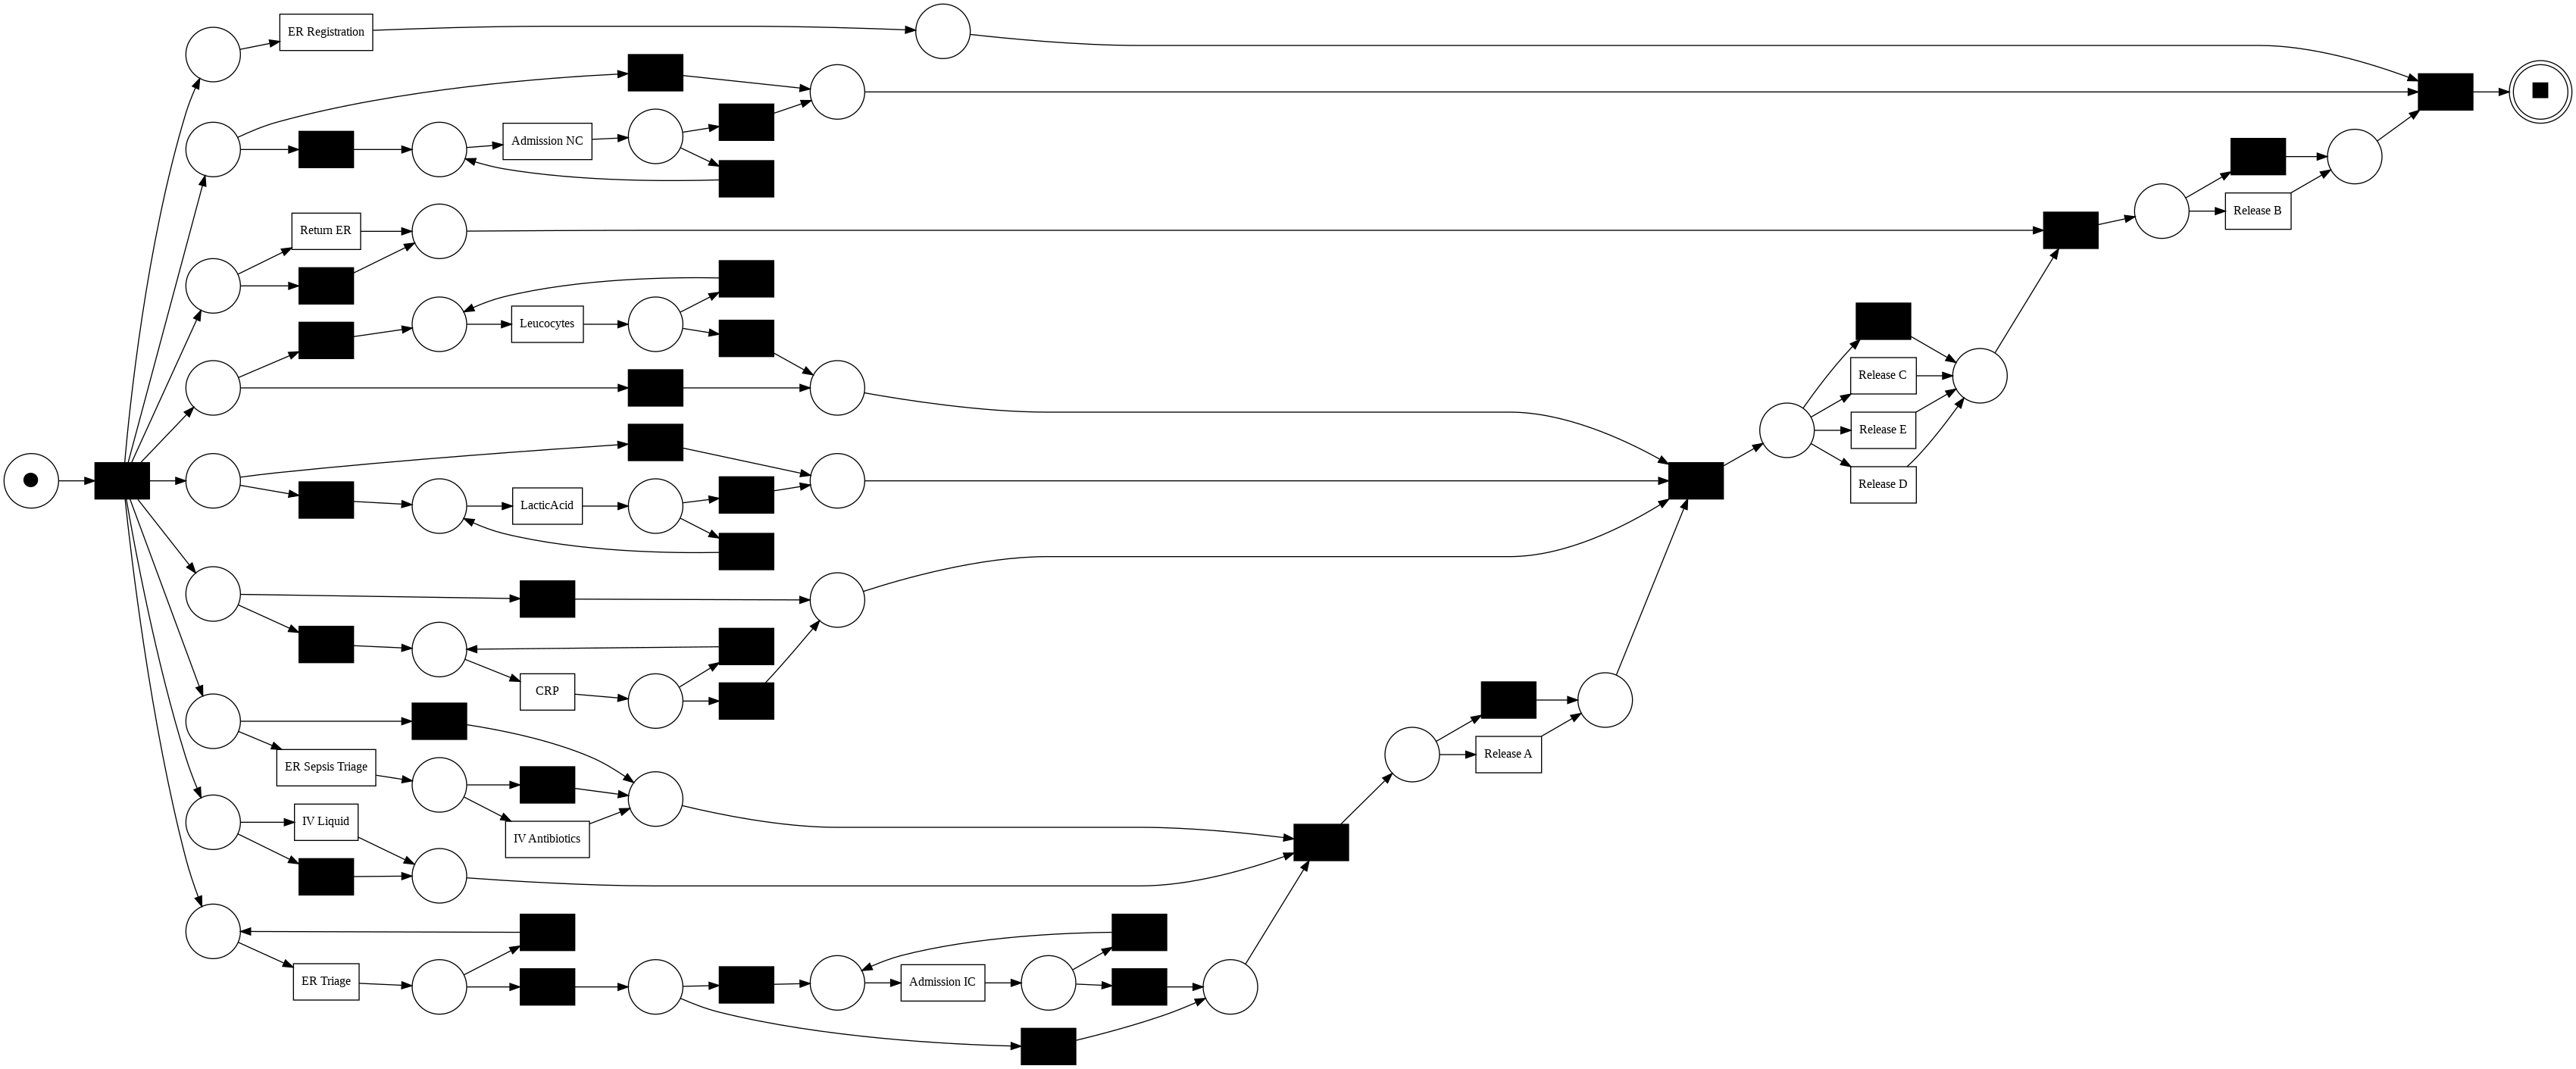

In [34]:
# Apply the Inductive Miner to discover a Petri net
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)

# Visualize the Petri net
pm4py.view_petri_net(net, initial_marking, final_marking)

## Heuristics miner

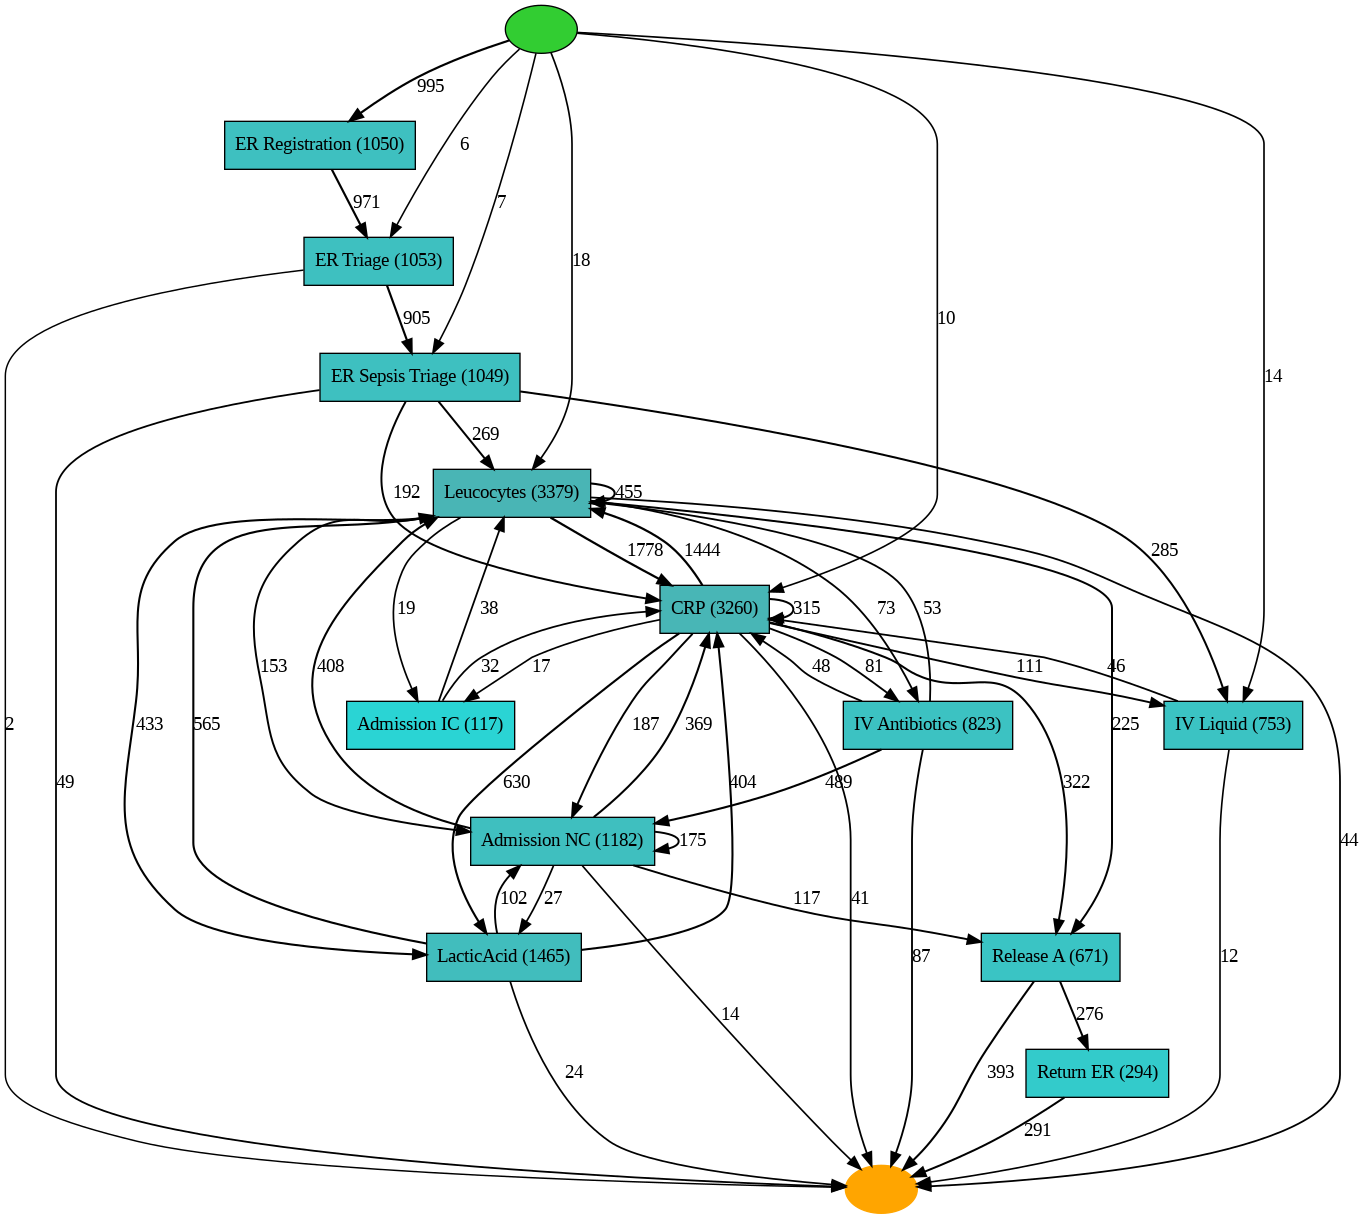

In [42]:
heu_net = pm4py.discover_heuristics_net(log, dependency_threshold=0.99)
pm4py.view_heuristics_net(heu_net)

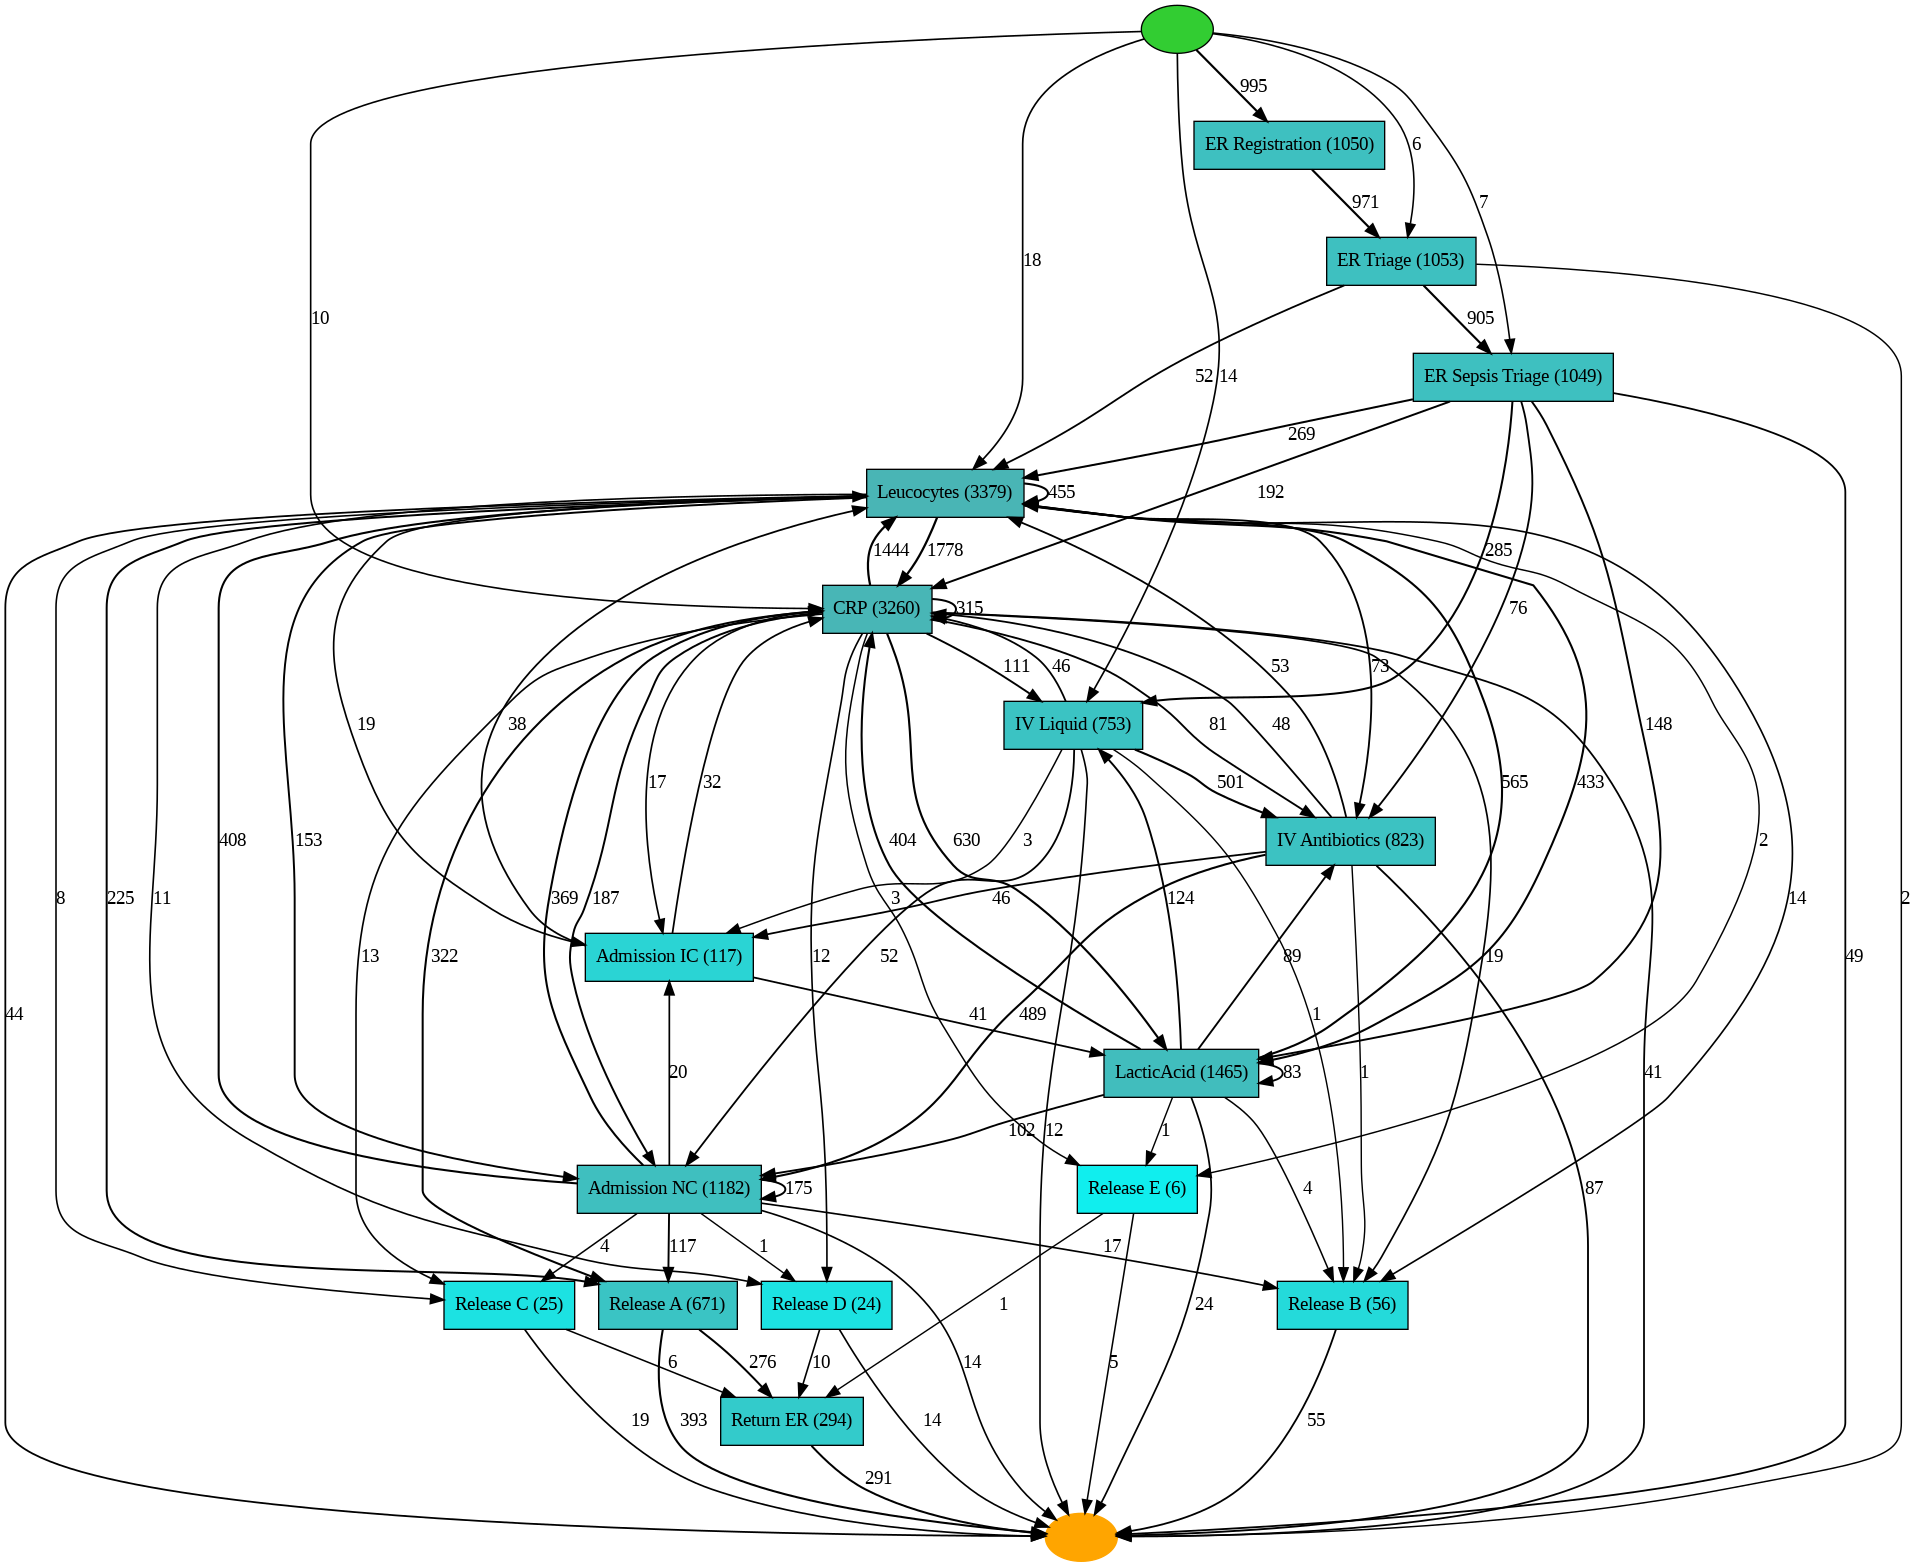

In [41]:
heu_net = pm4py.discover_heuristics_net(log, dependency_threshold=0.5)
pm4py.view_heuristics_net(heu_net)